# Intro
In this notebook we'll develop a LSTM for predictive maintenance on FD004 to predict the Remaining Useful Life (RUL) of the engines. FD004 is characterized by the engines running on different operating conditions and developing one of two possible faults.(see metadata below). You can find a full explanation of the code in my accompanying blogpost [here](https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3?sk=b2bd1590168a6eaab5d13857807afbda)  

Data Set: FD004  
Train trjectories: 248  
Test trajectories: 249  
Conditions: SIX  
Fault Modes: TWO (HPC Degradation, Fan Degradation)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [ ]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
!git clone https://github.com/edwardzjl/CMAPSSData.git

Cloning into 'CMAPSSData'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16 (from 1)
Receiving objects: 100% (16/16), 11.96 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

# important: set random seeds to get reproducible results

Initial weights of neural networks are generated randomly. Due to this randomness results may vary, making it very difficult to judge whether the changes you make are because of this randomness or actuall improvements to model performance. Therefore we wan't to control the random initialization to allow comparing between iterations.

#### Find a more thorough explanation on getting reproducible results [here](https://towardsdatascience.com/primer-on-developing-reproducible-neural-networks-in-jupyter-notebook-2f88d23b7c8d?sk=dbb8d4efdc36aa676cb97857b946c5ca)

In [ ]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
dir_path = '/content/CMAPSSData/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'


In [ ]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None,
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None,
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None,
                 names=['RemainingUsefulLife'])

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # get last row of each engine

# Baseline model

In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.43794228641221, R2:0.7220738975061538
test set RMSE:34.593735911368306, R2:0.5974472412019691


# Plotting

In [ ]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)

    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [ ]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.27462144 -0.32737159 -0.92936463  1.47860752 -0.92936463 -0.92936463
  0.27462144  0.87661448 -0.32737159  0.87661448 -2.73534374  1.47860752
 -0.92936463  0.87661448 -1.53135767  0.87661448 -0.92936463  0.87661448
 -0.92936463 -0.32737159 -0.92936463  1.47860752  0.27462144  1.47860752
  0.27462144  0.87661448 -0.92936463  0.87661448  0.27462144  2.08060055


In [ ]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))

    if unit_nr:
        plt.plot('RUL', signal_name,
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

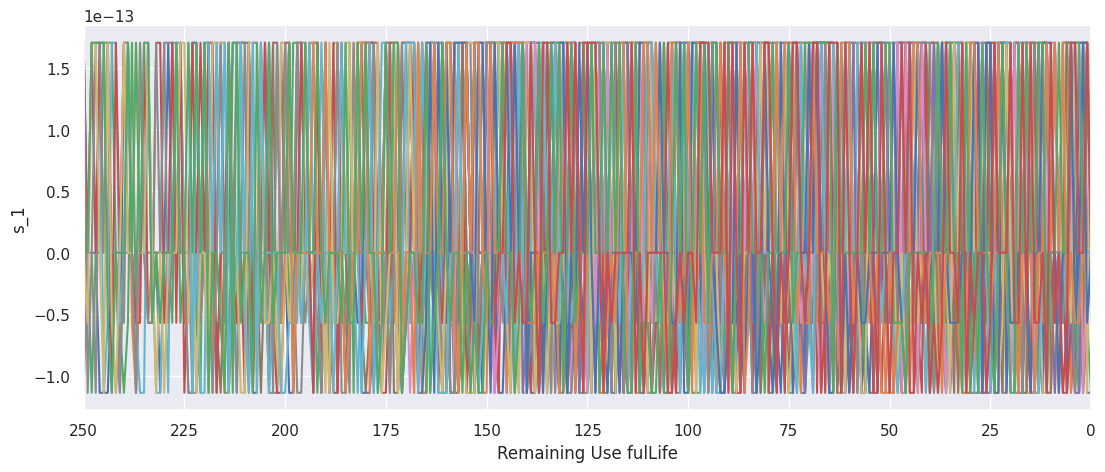

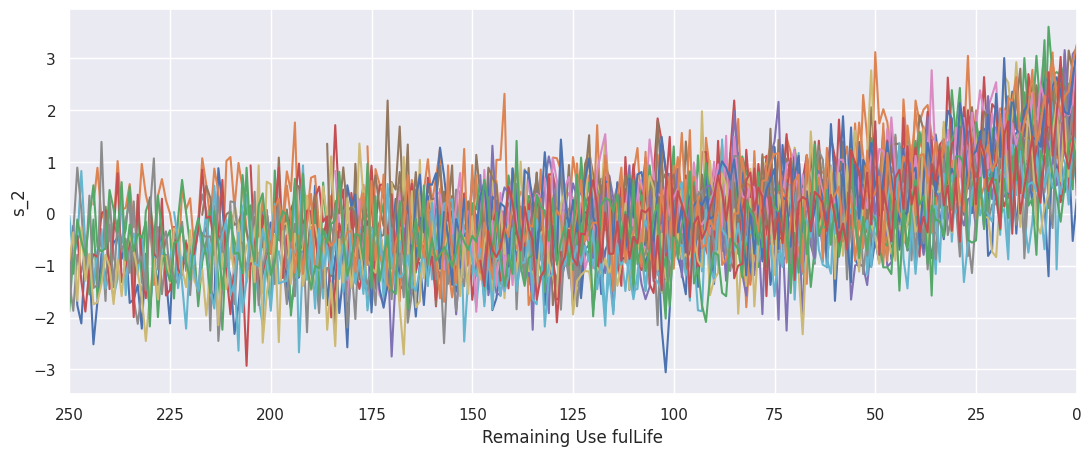

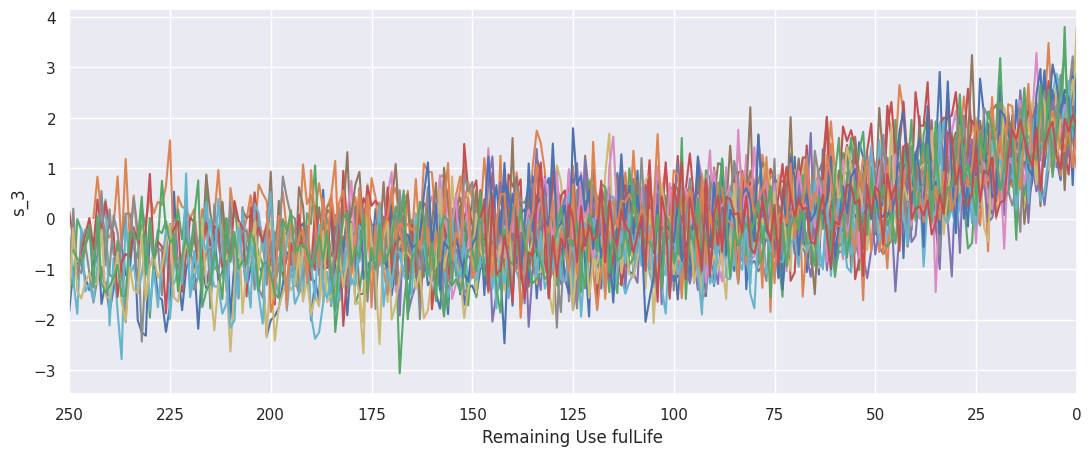

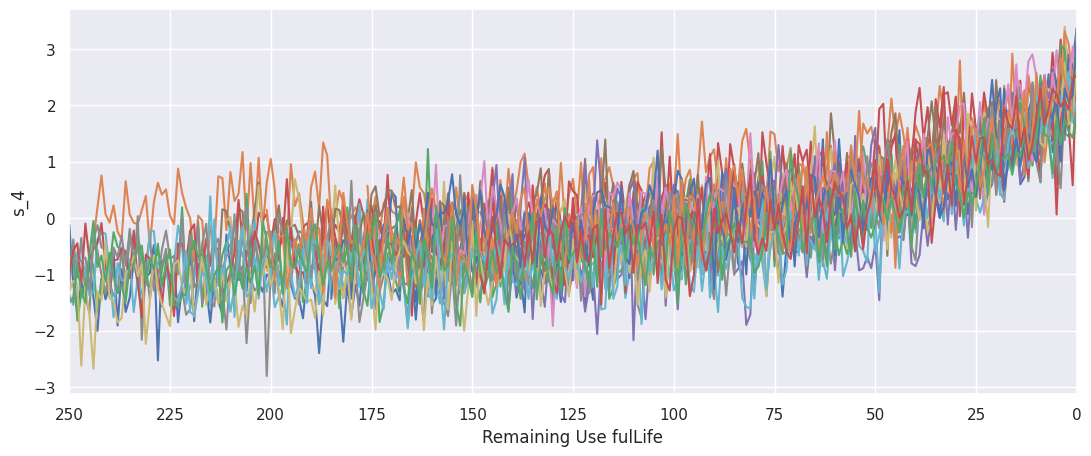

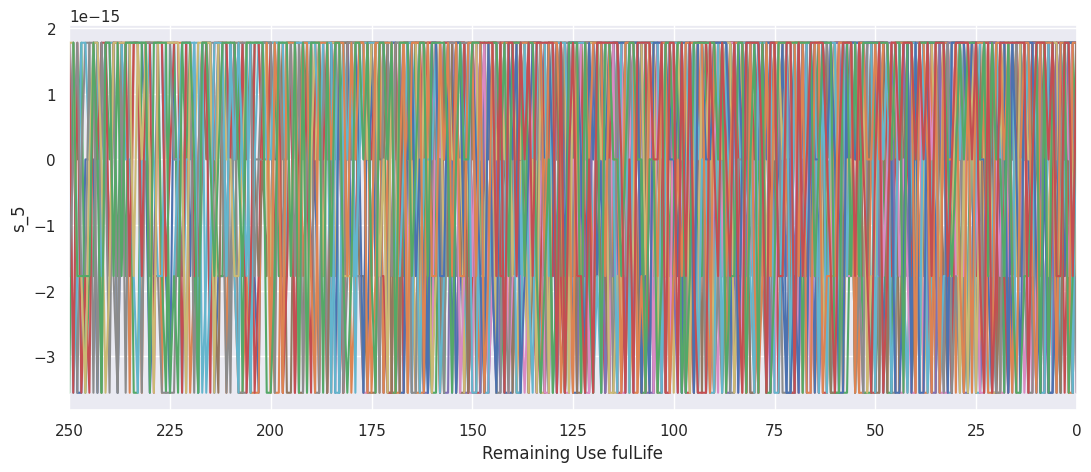

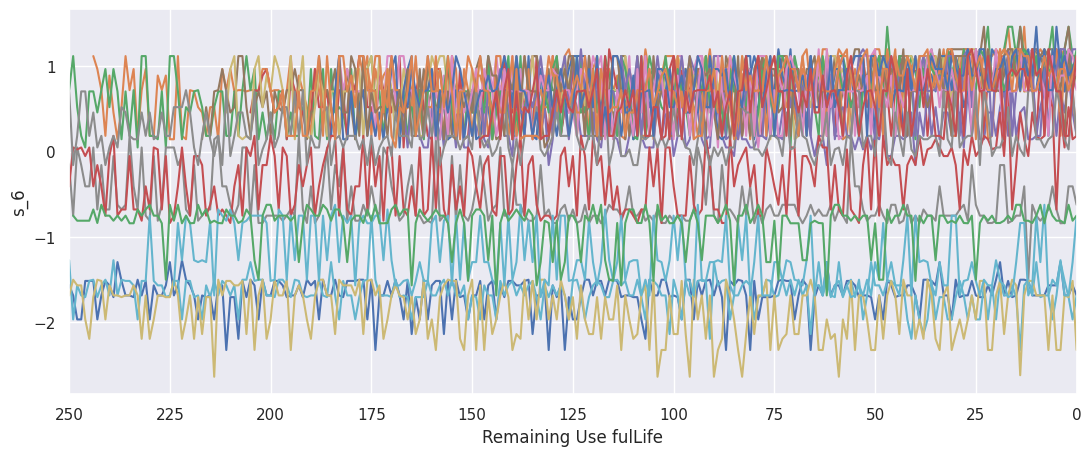

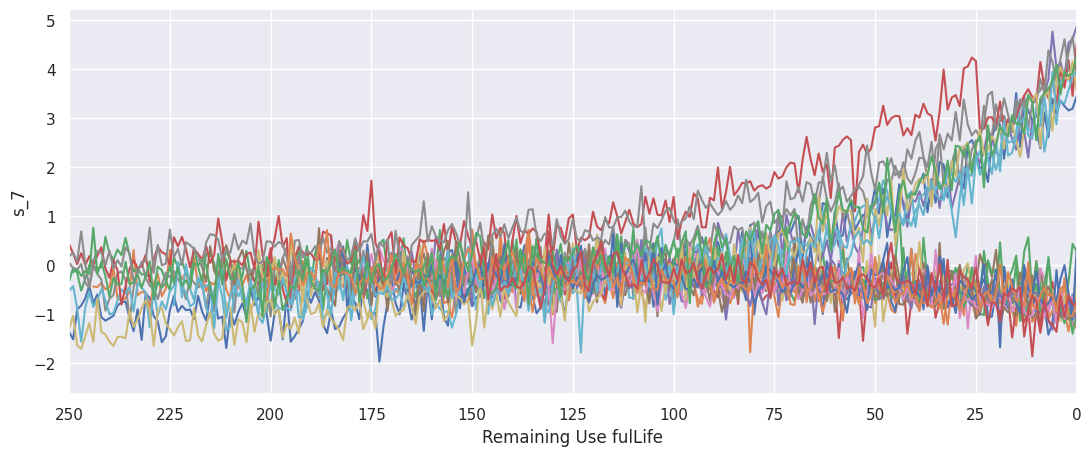

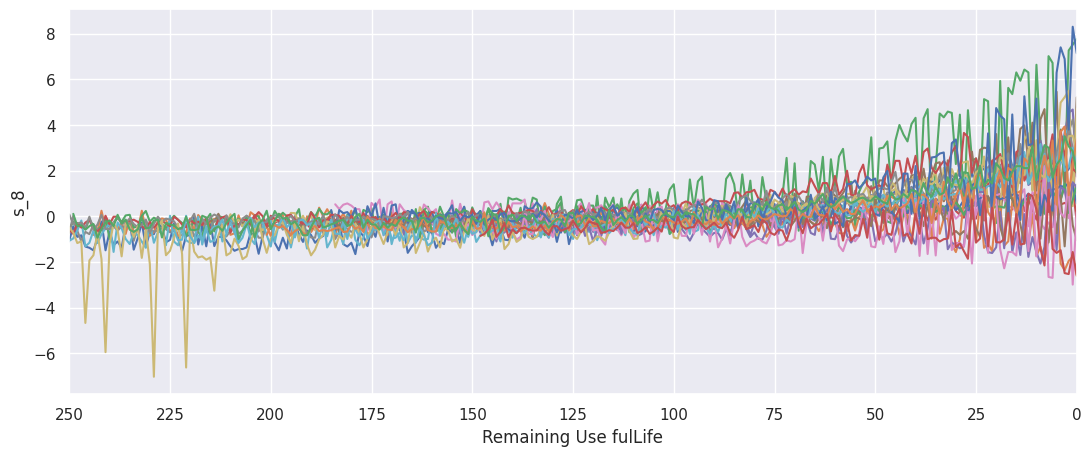

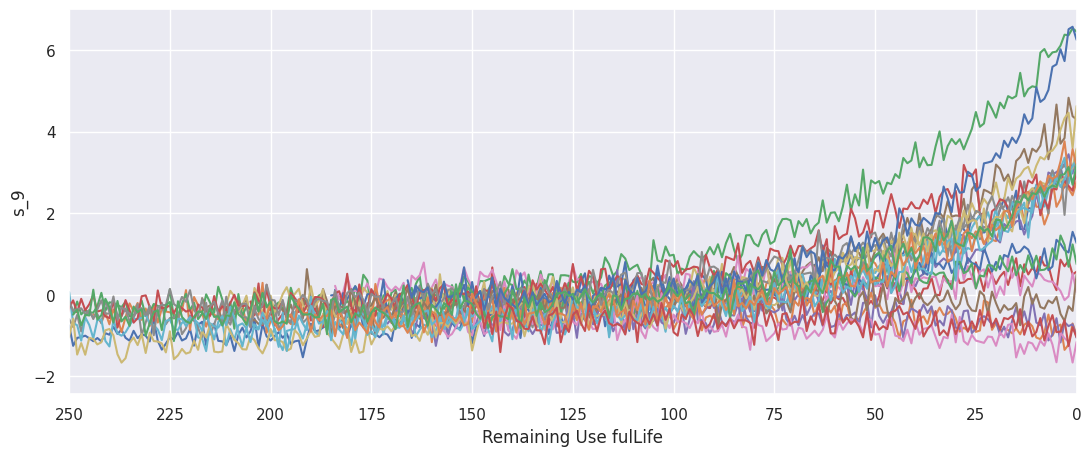

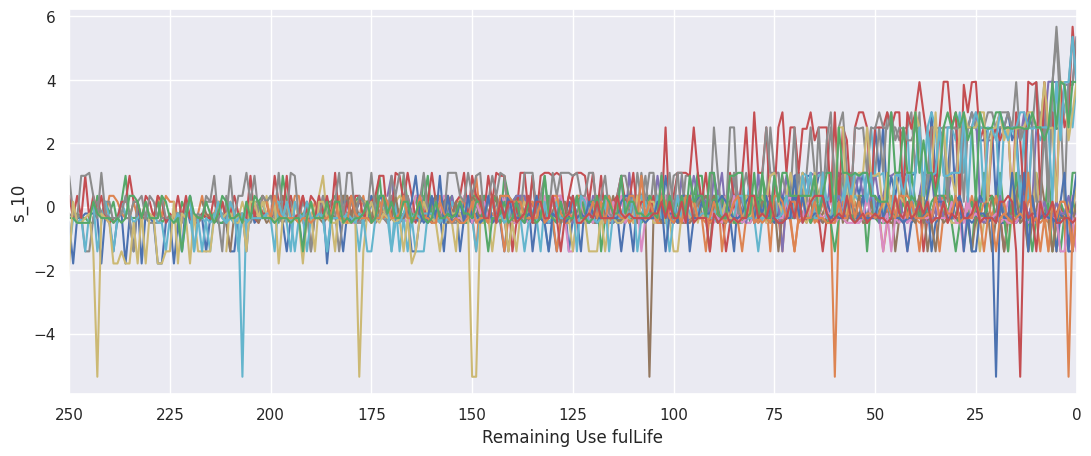

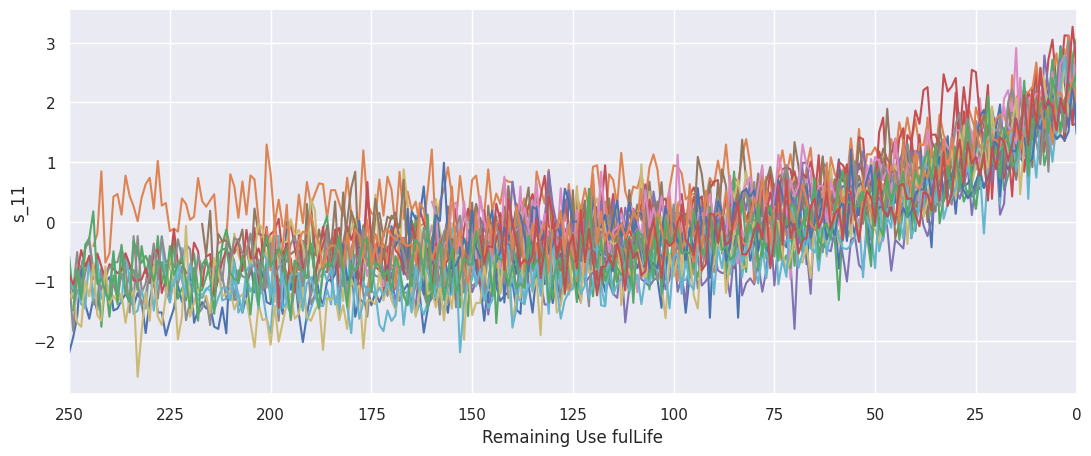

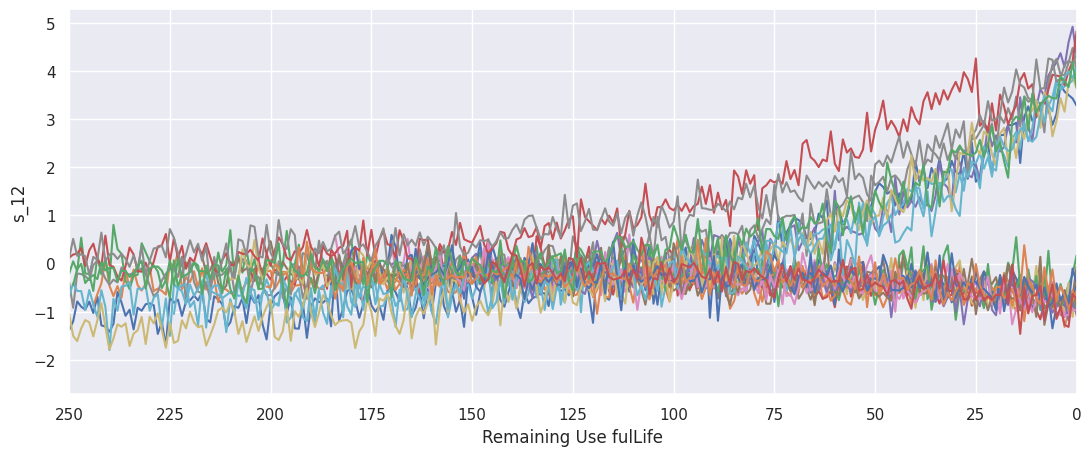

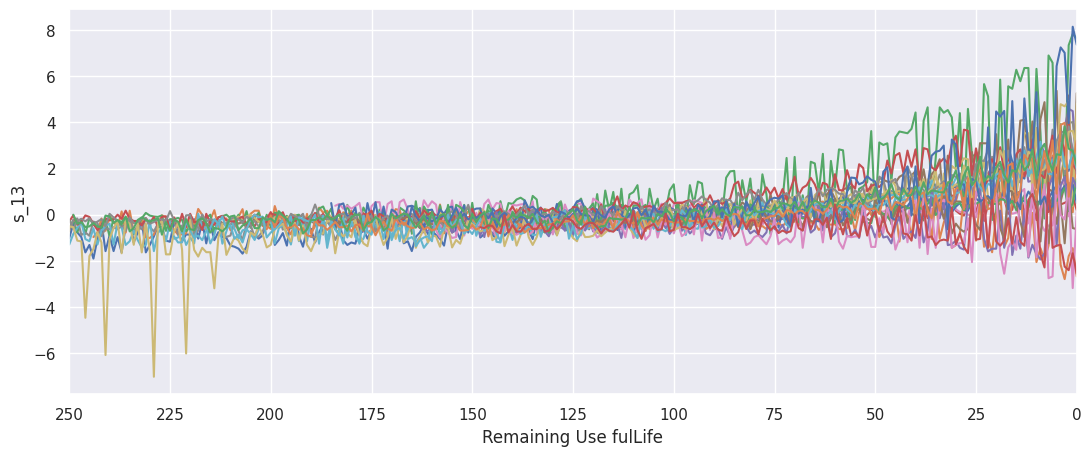

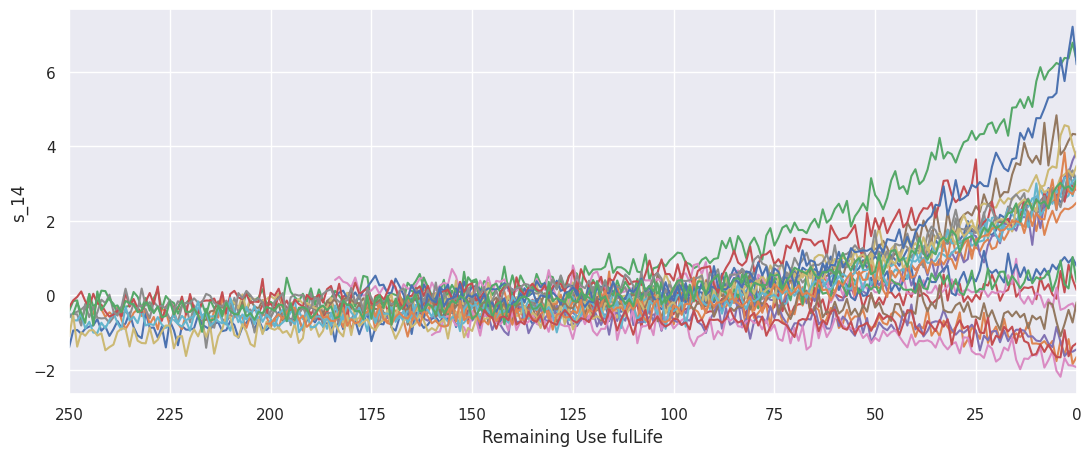

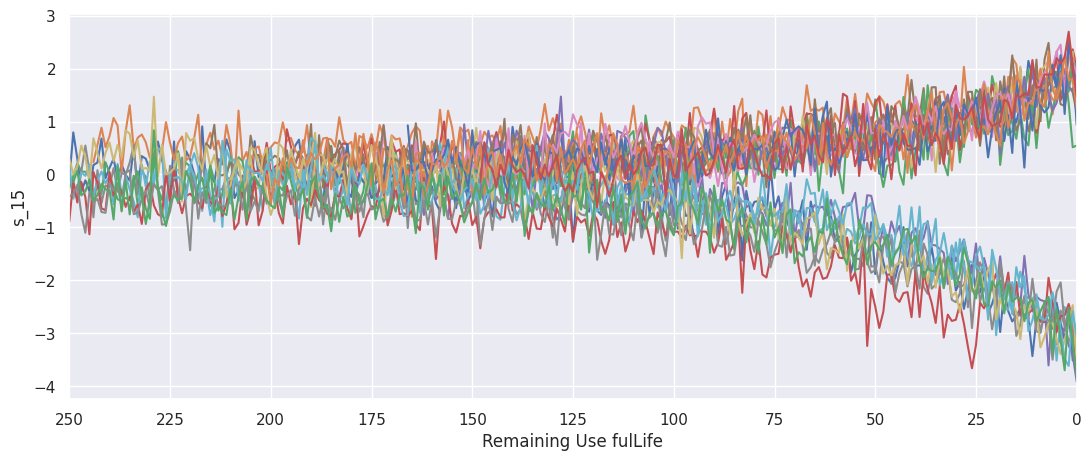

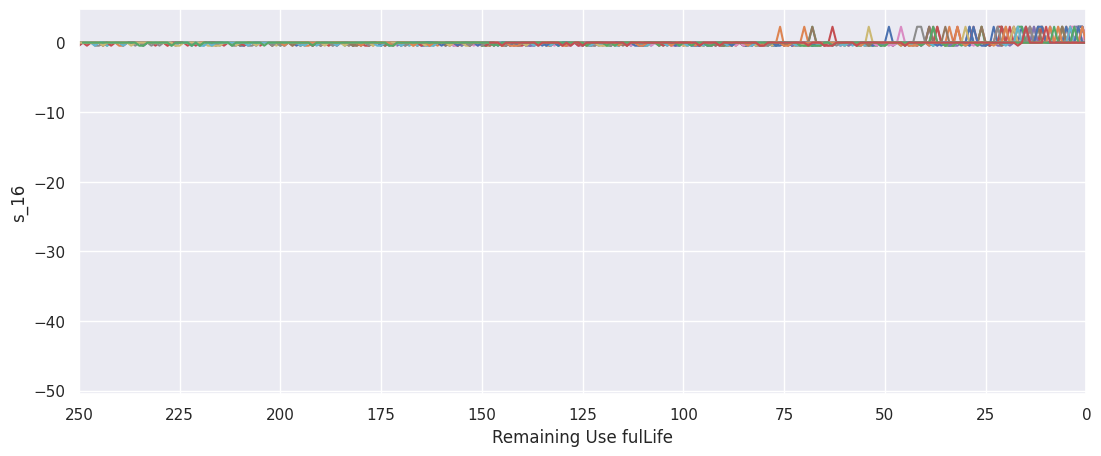

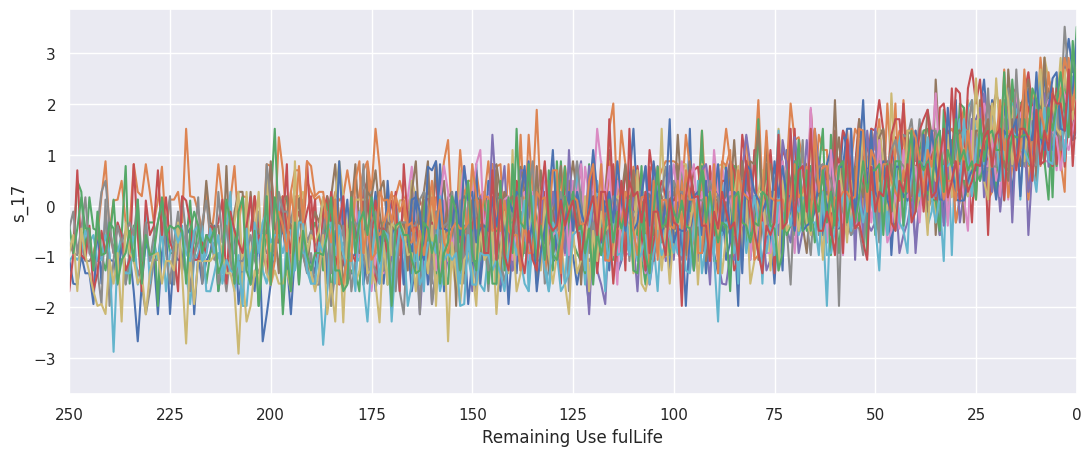

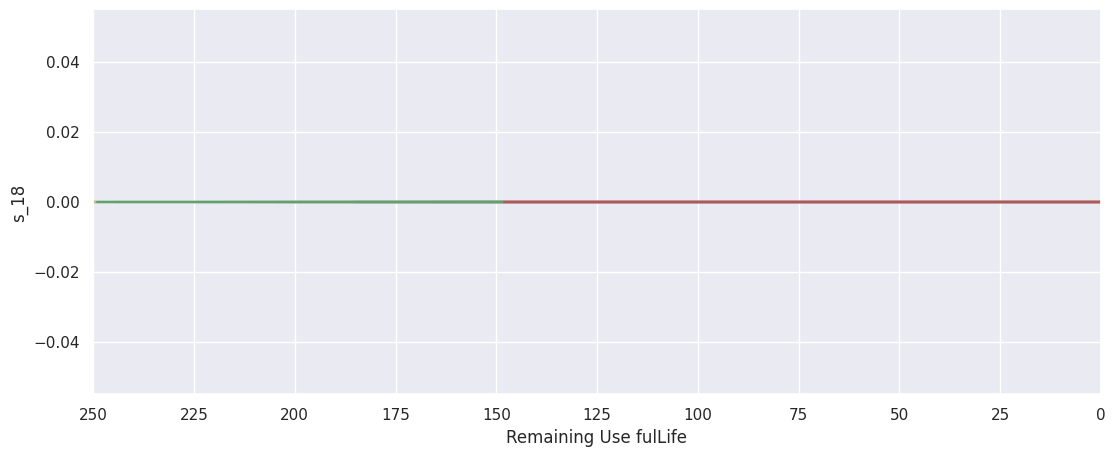

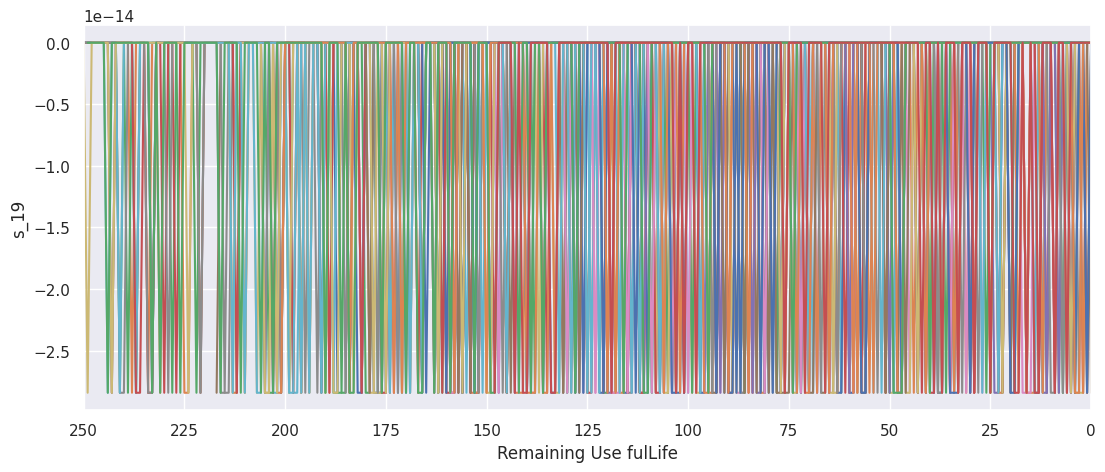

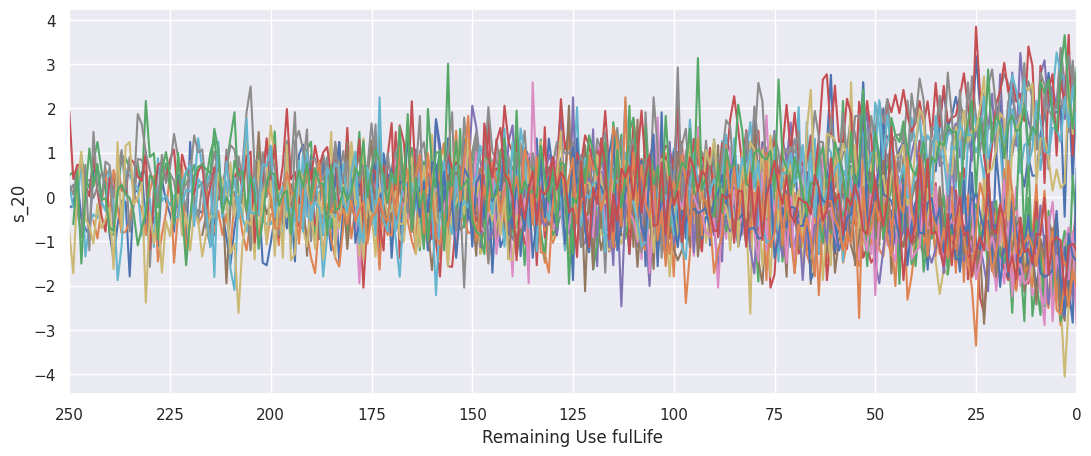

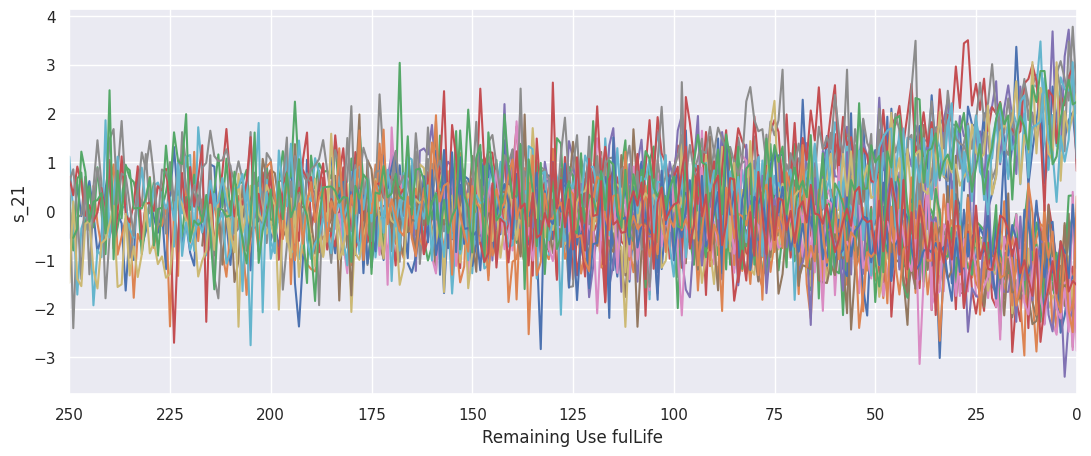

In [ ]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

Note, useable sensors seem to be ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'], however sensors ['s_8', 's_9', 's_13', 's_14'] might confuse the model as they don't seem to distinguish between the two fault modes very well. Something we'll have to test during model development

In [ ]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# Data preparation
We can reuse some of the functions from last time, like exponential_smoothing and train_val_group_split

In [ ]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):

    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

## Sequences

In [ ]:
d = {'unit_nr': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]}
example_df = pd.DataFrame(data=d)
example_df

unit_nr     X    y
0        1  10.0  1.4
1        1  10.2  1.4
2        1  10.4  1.3
3        1  10.6  1.2
4        1  10.8  1.1
5        2  20.0  2.4
6        2  20.2  2.4
7        2  20.4  2.3
8        2  20.6  2.2
9        2  20.8  2.1

code for generating sequences is based on code in Microsoft Azure's github repository [https://github.com/Azure/lstms_for_predictive_maintenance]. However, considerable changes have been made.  
See example_df above, the traditional generator would create a sequence [10., 10.2, 10.4, 10.6] to predict [1.1], where I want the sequence [10., 10.2, 10.4, 10.6, 10.8] to predict [1.1]. The latter is in line with previous implementations throughout the series, plus we can add that tiny bit more information to perform our predictions.  
The original code would not consider engines if the number of records for that engine was lower than the sequence that's being generated, effectively removing part of the test set. I do want to include all test engines, therefore I've implemented padding. see further down below.

In [ ]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


In [ ]:
gen = gen_train_data(example_df[example_df['unit_nr']==1], sequence_length=4, columns=['X'])
list(gen)

[array([[10. ],
        [10.2],
        [10.4],
        [10.6]]),
 array([[10.2],
        [10.4],
        [10.6],
        [10.8]])]

In [ ]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

For the labels we'll do something similar

In [ ]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [ ]:
label = gen_labels(example_df[example_df['unit_nr']==1], sequence_length=4, label=['y'])
label

array([[1.2],
       [1.1]])

In [ ]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

In [ ]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

In [ ]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [ ]:
# notice the masked value I passed is a float,
# it should be the same datatype as the data you're working with
gen = (list(gen_test_data(example_df[example_df['unit_nr']==unit_nr], sequence_length=6, columns=['X'], mask_value=-99.))
           for unit_nr in example_df['unit_nr'].unique())
next(gen)

[array([[-99. ],
        [ 10. ],
        [ 10.2],
        [ 10.4],
        [ 10.6],
        [ 10.8]])]

# LSTM

In [ ]:
# # test to see if results are better on the first initialization
# remaining_sensors = ['s_2', 's_3', 's_4', 's_7',
#        's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
# drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [ ]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

<ipython-input-28-933c843e600e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transfo

In [ ]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh', use_cudnn=False))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm.weights.h5')

In [ ]:
!pip install mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok -q

In [ ]:
import tensorflow as tf
import mlflow
import os

class MLflowModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, experiment_name, run_name=None):
        super().__init__()
        self.experiment_name = experiment_name
        self.run_name = run_name
        self.example_input = np.random.random((1, sequence_length, train_array.shape[2]))

    def on_epoch_end(self, epoch, logs=None):
        # Save the model to a temp directory
        model_path = f"temp_model_epoch_{epoch+1}.tf"

        # Log the model to MLflow
        # mlflow.tensorflow.log_model(
        #     model=self.model,
        #     artifact_path=model_path,
        #     input_example=self.example_input,
        # )

        # print(f"✅ Model logged to MLflow at {model_path}")


        # predict and evaluate
        y_hat_val = model.predict(val_split_array)
        evaluate(val_split_label, y_hat_val, 'val')
        mlflow.log_metric('train_rmse', np.sqrt(mean_squared_error(val_split_label, y_hat_val)))
        mlflow.log_metric('train_r2', r2_score(val_split_label, y_hat_val))

        # y_hat_test = model.predict(test_array)
        # evaluate(y_test, y_hat_test)
        # mlflow.log_metric('test_rmse', np.sqrt(mean_squared_error(y_test, y_hat_test)))
        # mlflow.log_metric('test_r2', r2_score(y_test, y_hat_test))



In [ ]:
# mlflow.set_tracking_uri("databricks")
# mlflow.create_experiment(
#     "/Users/qazpoigoes@gmail.com/lstm_v1",
#     artifact_location="dbfs:/Volumes/test/tracking/experiments/mlflow-artifacts/",
#     tags={"version": "v1", "priority": "P1"},
# )
local_registry = "sqlite:///mlruns.db"
mlflow.set_tracking_uri(local_registry)


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm.weights.h5')  # weights are reloaded to ensure reproducible results

mlflow.set_experiment("/content/lstm_v1")

callbacks = [MLflowModelCheckpoint(experiment_name="/content/lstm_v1")]

mlflow.autolog(True)

# mlflow.tensorflow.autolog(

# )

with mlflow.start_run() as run:

    params = {
        "epochs": 5,
        "batch_size": 32,
    }

    history = model.fit(train_split_array, train_split_label,
                        validation_data=(val_split_array, val_split_label),
                        callbacks=[callbacks],
                        **params)
    y_hat_train = model.predict(train_array)
    evaluate(label_array, y_hat_train, 'train')
    mlflow.log_metric('train_rmse', np.sqrt(mean_squared_error(label_array, y_hat_train)))
    mlflow.log_metric('train_r2', r2_score(label_array, y_hat_train))

    y_hat_test = model.predict(test_array)
    evaluate(y_test, y_hat_test)
    mlflow.log_metric('test_rmse', np.sqrt(mean_squared_error(y_test, y_hat_test)))
    mlflow.log_metric('test_r2', r2_score(y_test, y_hat_test))



2025/04/13 12:42:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/04/13 12:42:17 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Epoch 1/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:55.54397627809203, R2:-0.7997353076934814
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - loss: 7140.6016 - val_loss: 3085.1323
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:32.859688910174384, R2:0.3701145052909851
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2471.6855 - val_loss: 1079.7592
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:22.28118836553537, R2:0.7103914022445679
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 829.1362 - val_loss: 496.4512
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:19.56178004490876, R2:0.7767705917358398
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 356.6624 - val_loss: 382.6631
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:19.090665827270552, R2:0.78739333152771
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 257.4354 - val_loss: 364.4535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


2025/04/13 12:43:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`."
2025/04/13 12:43:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
train set RMSE:15.897501700038733, R2:0.8512811660766602
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
test set RMSE:28.974428675814192, R2:0.7176045775413513


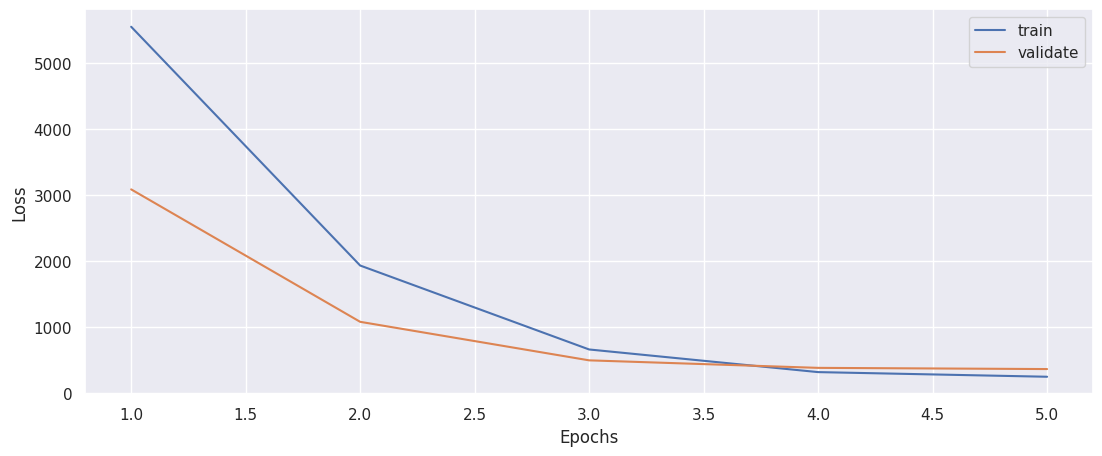

In [ ]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")# run tracking UI in the background

In [ ]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token("2TsVFigTBVmW71BgovKSVHvocBZ_2QNgMrR2MeNJFWy7Mgswj")

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://6665-34-169-209-111.ngrok-free.app


# Test Serving

In [ ]:
from pathlib import Path
run_id = list(Path('/content/mlruns').glob("*/*"))[0].name
run_id

'8b0de5b40d9b456bac6af1e58489766c'

In [ ]:
import mlflow
import json
model_uri = f"runs:/{run_id}/model"

# Replace INPUT_EXAMPLE with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
input_data = train_array[:5]

print(input_data.shape)
input_data = json.loads(mlflow.models.convert_input_example_to_serving_input(input_data))
json.dump(input_data, open('/content/input.json', 'w'))
# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=None,
    input_path='/content/input.json',
    env_manager="local"
)

2025/04/13 12:43:57 INFO mlflow.models.python_api: It is highly recommended to use `uv` as the environment manager for predicting with MLflow models as its performance is significantly better than other environment managers. Run `pip install uv` to install uv. See https://docs.astral.sh/uv/getting-started/installation for other installation methods.


(5, 20, 14)


2025/04/13 12:43:57 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
{"predictions": [[122.02627563476562], [121.44227600097656], [121.93375396728516], [122.1298599243164], [122.24442291259766]]}

# Hyperparameter tuning
parameters to tune:
    - alpha, filter strength
    - sequence_length
    - epochs
    - number of layers
    - nodes per layer
    - dropout
    - optimizer, learning rate (I choose to not tune this parameter)
    - activation function
    - batch size
    - included sensors

In [ ]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
# epoch_list = list(np.arange(5,20+1,5))
epoch_list = [5,10,15]
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
# batch_size_list = [32, 64, 128, 256]
batch_size_list = [128,256,512]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

np.int64(28224)

In [ ]:
train['RUL'].clip(upper=125, inplace=True)

def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    return X_train_interim, X_test_interim

<ipython-input-42-aedf2f3a6fab>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)


In [ ]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [ ]:
# random grid search takes significant time, set iterations to a higher number if you truly want to tune parameters
ITERATIONS = 25

In [ ]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout',
                                'activation', 'batch_size',
                                'sequence_length', 'sensor_length'])

weights_file = 'fd004_model.weights.h5'

res = []

for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)

    mse = []

    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in tqdm(gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique())):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1)
        mse.append(history.history['val_loss'][-1])

    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha,
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout,
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    res.append(pd.DataFrame(d, index=[0]))

results = pd.concat(res, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.274621

Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9844.0850

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 9839.5801 - val_loss: 8300.7949
Epoch 2/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8214.7031

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8210.1992 - val_loss: 7479.1538
Epoch 3/5
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7516.1650

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7510.3408 - val_loss: 6951.5474
Epoch 4/5
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6997.1885

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6993.3198 - val_loss: 6486.9009
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6532.9727

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6531.7939 - val_loss: 6061.4966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025/04/13 12:44:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


1it [00:32, 32.08s/it]2025/04/13 12:44:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0387cc337fc44dde84fcb00adb38c9e3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9745.7393

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9705.5430 - val_loss: 8596.2559
Epoch 2/5
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8100.0015

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8081.5830 - val_loss: 7785.8232
Epoch 3/5
83/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7409.9121

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7399.1187 - val_loss: 7247.7666
Epoch 4/5
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6897.2153

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6894.5894 - val_loss: 6772.3291
Epoch 5/5
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6448.3086

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6441.5391 - val_loss: 6336.2290


WARNI [tensorflow] 5 out of the last 1780 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7bd5c723d4e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


2025/04/13 12:44:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "
WARNI [tensorflow] 6 out of the last 1781 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7bd5d4bbc5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2it [00:48, 23.05s/it]2025/04/13 12:44:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea4d41a3dc7845dd90ae8ef6c6120fa6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9820.8564

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9807.4150 - val_loss: 8405.7959
Epoch 2/5
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8204.5537

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8193.3066 - val_loss: 7591.0732
Epoch 3/5
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7488.4341

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7484.0649 - val_loss: 7054.2607
Epoch 4/5
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6978.8101

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6969.4946 - val_loss: 6582.8838
Epoch 5/5
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6513.0215

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6508.2295 - val_loss: 6151.1460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025/04/13 12:45:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


3it [01:05, 21.81s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9125.4893

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9091.7695 - val_loss: 7142.0054
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7063.5610

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7061.3730 - val_loss: 6272.0889
Epoch 3/10
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6243.2607

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6232.3940 - val_loss: 5562.1982
Epoch 4/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5537.6187

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5531.1001 - val_loss: 4931.9585
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4911.6631

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4910.3384 - val_loss: 4392.3037
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4385.7773

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4384.6245 - val_loss: 3927.9023
Epoch 7/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3920.7976

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3915.3582 - val_loss: 3416.9719
Epoch 8/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3400.4851

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3396.0337 - val_loss: 3005.7317
Epoch 9/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2993.4155

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2988.7881 - val_loss: 2642.8191
Epoch 10/10
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2632.6245

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2627.7024 - val_loss: 2328.9634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


2025/04/13 12:45:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


1it [00:26, 26.49s/it]2025/04/13 12:45:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd88af2ae4df64fd3b50a2edc6d52a5d9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9124.2002

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9077.9189 - val_loss: 7473.9185
Epoch 2/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7054.1509

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7045.6558 - val_loss: 6582.9585
Epoch 3/10
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6234.0938

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6224.4854 - val_loss: 5839.4272
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5519.6416

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5517.5928 - val_loss: 5193.9385
Epoch 5/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4926.3657

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4920.7490 - val_loss: 4637.8071
Epoch 6/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4395.6958

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4392.6001 - val_loss: 4154.7090
Epoch 7/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3936.5515

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3931.5916 - val_loss: 3646.1648
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3420.3210

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3418.9768 - val_loss: 3199.9058
Epoch 9/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3016.9387

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3014.5444 - val_loss: 2826.0723
Epoch 10/10
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2664.2834

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2660.0024 - val_loss: 2490.3613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


2025/04/13 12:45:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


2it [00:54, 27.55s/it]2025/04/13 12:46:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2767aca212e34d7abd485457ceac6009', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9084.5771

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9076.2490 - val_loss: 7256.6821
Epoch 2/10
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7060.7798

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7053.5166 - val_loss: 6376.0122
Epoch 3/10
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6233.0049

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6219.2993 - val_loss: 5656.7388
Epoch 4/10
83/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5537.4727

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5525.7207 - val_loss: 5038.7134
Epoch 5/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4938.7676

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4931.2041 - val_loss: 4483.3848
Epoch 6/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4393.6152

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4387.2866 - val_loss: 4004.6406
Epoch 7/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3923.6851

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3916.3623 - val_loss: 3471.1609
Epoch 8/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3402.5366

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3396.6716 - val_loss: 3042.6199
Epoch 9/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2992.6648

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2987.7222 - val_loss: 2674.9185
Epoch 10/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2638.4663

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2636.6934 - val_loss: 2348.2300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


2025/04/13 12:46:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


3it [01:22, 27.47s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9017.8740

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 9014.7363 - val_loss: 7474.4058
Epoch 2/15
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7418.2549

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7405.7988 - val_loss: 6382.0518
Epoch 3/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6359.6694

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6347.8218 - val_loss: 5471.7686
Epoch 4/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5425.3110

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5413.4692 - val_loss: 4570.0210
Epoch 5/15
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4531.5371

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4523.2832 - val_loss: 3850.6924
Epoch 6/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3829.4937

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3819.4678 - val_loss: 3253.4609
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3226.3950

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3225.5823 - val_loss: 2749.9741
Epoch 8/15
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2722.3103

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2720.9592 - val_loss: 2326.0273
Epoch 9/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2304.4355

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2298.5024 - val_loss: 1970.5093
Epoch 10/15
163/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1950.0343

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1945.4325 - val_loss: 1671.1899
Epoch 11/15
161/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1647.0840

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1642.5708 - val_loss: 1423.9387
Epoch 12/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1392.4917

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1389.2103 - val_loss: 1218.8048
Epoch 13/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1177.3112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1174.9033 - val_loss: 1032.8177
Epoch 14/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 984.5664

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 982.6571 - val_loss: 893.4250
Epoch 15/15
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 841.4914

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 840.1945 - val_loss: 787.6234
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


2025/04/13 12:47:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


1it [00:37, 37.87s/it]2025/04/13 12:47:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '59091f3f5b16442cb1a988bb3f9fb335', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8926.9551

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 8923.7715 - val_loss: 7875.0947
Epoch 2/15
160/167 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7361.1870

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7346.7627 - val_loss: 6762.1021
Epoch 3/15
161/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6326.6396

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6316.0273 - val_loss: 5814.7139
Epoch 4/15
162/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5404.3960

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5395.3193 - val_loss: 4886.7471
Epoch 5/15
160/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4544.0513

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4534.4204 - val_loss: 4139.3789
Epoch 6/15
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3850.5039

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3847.4302 - val_loss: 3513.7061
Epoch 7/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3268.1951

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3264.7471 - val_loss: 2981.6409
Epoch 8/15
162/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2775.4307

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2771.1152 - val_loss: 2528.5989
Epoch 9/15
162/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2355.9302

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2352.2915 - val_loss: 2142.7297
Epoch 10/15
162/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2000.4067

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1997.3308 - val_loss: 1814.9050
Epoch 11/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1699.5830

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1699.1421 - val_loss: 1538.1560
Epoch 12/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1449.7200

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1448.2860 - val_loss: 1306.0875
Epoch 13/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1237.6885

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1236.2933 - val_loss: 1089.3771
Epoch 14/15
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1037.6166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1036.8600 - val_loss: 921.1475
Epoch 15/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 894.7345

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 893.9060 - val_loss: 789.3688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


2025/04/13 12:47:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


2it [01:21, 41.21s/it]2025/04/13 12:47:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0233f8340212459590846969ef7cf4a5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8919.6133

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 8916.8330 - val_loss: 7614.9971
Epoch 2/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7338.3047

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7326.7798 - val_loss: 6516.7349
Epoch 3/15
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6292.9468

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6288.2534 - val_loss: 5584.2549
Epoch 4/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5368.3145

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5358.6973 - val_loss: 4671.5840
Epoch 5/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4505.3979

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4497.8145 - val_loss: 3942.8486
Epoch 6/15
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3805.7986

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3801.1182 - val_loss: 3332.8958
Epoch 7/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3223.2734

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3220.0198 - val_loss: 2816.7400
Epoch 8/15
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2731.2571

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2727.5247 - val_loss: 2379.0796
Epoch 9/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2314.1604

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2311.9170 - val_loss: 2008.4498
Epoch 10/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1958.1145

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1956.2344 - val_loss: 1695.5272
Epoch 11/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1665.7035

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1663.1932 - val_loss: 1432.7510
Epoch 12/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1414.9352

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1412.8866 - val_loss: 1211.4825
Epoch 13/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1194.9027

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1193.6974 - val_loss: 1008.2739
Epoch 14/15
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1007.0839

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1005.9727 - val_loss: 856.6266
Epoch 15/15
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 864.6222

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 863.8030 - val_loss: 736.9113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


2025/04/13 12:48:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


3it [01:58, 39.54s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9680.4873

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 9675.9688 - val_loss: 8459.4150
Epoch 2/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8511.3467

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8482.9873 - val_loss: 7714.2402
Epoch 3/10
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7779.1553

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7761.6948 - val_loss: 7080.6509
Epoch 4/10
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7135.9453

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7132.0615 - val_loss: 6493.4868
Epoch 5/10
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6560.4448

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6543.3853 - val_loss: 5957.5796
Epoch 6/10
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6024.9863

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6009.2319 - val_loss: 5470.9517
Epoch 7/10
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5529.0713

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5516.4194 - val_loss: 5022.7710
Epoch 8/10
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5078.5439

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5067.0327 - val_loss: 4612.3726
Epoch 9/10
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4667.1362

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4656.2808 - val_loss: 4234.8540
Epoch 10/10
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4293.8169

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4276.9048 - val_loss: 3887.2014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


2025/04/13 12:48:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


1it [00:23, 23.92s/it]2025/04/13 12:48:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4f605421fe1948c987ea1f1ae52f0c3f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9589.8408

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 9585.3945 - val_loss: 8813.7900
Epoch 2/10
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8412.5439

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8405.2529 - val_loss: 8054.0840
Epoch 3/10
85/90 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7707.9741

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7695.2612 - val_loss: 7405.0464
Epoch 4/10
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7078.5361

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7068.6572 - val_loss: 6796.3857
Epoch 5/10
79/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6505.5444

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6484.3203 - val_loss: 6252.4937
Epoch 6/10
82/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5982.2930

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5967.6021 - val_loss: 5750.7637
Epoch 7/10
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5498.1245

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5483.0127 - val_loss: 5285.6567
Epoch 8/10
82/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5055.0112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5042.3633 - val_loss: 4861.3613
Epoch 9/10
78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4655.4639

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4638.3823 - val_loss: 4469.9736
Epoch 10/10
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4272.8633

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4261.1133 - val_loss: 4108.5752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


2025/04/13 12:49:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


2it [00:47, 24.00s/it]2025/04/13 12:49:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6dcd9c4ba7ca476296a9a9bc3ef2d3c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9618.1963

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 9614.0469 - val_loss: 8581.5586
Epoch 2/10
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8432.0439

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8425.6631 - val_loss: 7830.3970
Epoch 3/10
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7714.3613

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7709.0308 - val_loss: 7189.6187
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7076.2485

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7074.6152 - val_loss: 6588.1855
Epoch 5/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6508.7158

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6491.1719 - val_loss: 6049.2109
Epoch 6/10
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5972.3970

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5958.1743 - val_loss: 5557.4897
Epoch 7/10
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5482.8232

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5480.3125 - val_loss: 5108.3105
Epoch 8/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5054.1074

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5040.4932 - val_loss: 4684.7910
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4625.6733

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4624.6470 - val_loss: 4298.6401
Epoch 10/10
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4259.9141

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4247.4741 - val_loss: 3944.1162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


2025/04/13 12:49:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


3it [01:13, 24.34s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/15
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8883.0635

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 8881.7617 - val_loss: 7498.8975
Epoch 2/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7370.4497

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7366.0596 - val_loss: 6293.3994
Epoch 3/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6193.5747

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6189.8872 - val_loss: 5277.2808
Epoch 4/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5197.1514

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5191.5874 - val_loss: 4355.3643
Epoch 5/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4298.9111

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4296.2021 - val_loss: 3623.7983
Epoch 6/15
330/333 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3584.4812

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3582.7048 - val_loss: 3011.1409
Epoch 7/15
331/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2955.2002

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2953.8972 - val_loss: 2429.9729
Epoch 8/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2402.5771

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2400.9648 - val_loss: 1990.5920
Epoch 9/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1976.3689

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1975.0713 - val_loss: 1631.5800
Epoch 10/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1638.3108

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1637.1754 - val_loss: 1343.0106
Epoch 11/15
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1351.8580

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1351.4817 - val_loss: 1115.8835
Epoch 12/15
323/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1123.2581

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1121.5646 - val_loss: 933.4640
Epoch 13/15
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 938.3336

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 938.2192 - val_loss: 786.6577
Epoch 14/15
327/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 802.9021

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 802.0284 - val_loss: 664.8659
Epoch 15/15
328/333 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 671.4612

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 671.0003 - val_loss: 582.6133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


2025/04/13 12:50:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


1it [00:52, 52.81s/it]2025/04/13 12:50:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f3f01a288e2e42999b60f449ead92ab7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8773.1064

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 8771.8350 - val_loss: 7910.8877
Epoch 2/15
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7286.1147

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7281.0166 - val_loss: 6666.8940
Epoch 3/15
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6127.9917

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6125.9014 - val_loss: 5625.8345
Epoch 4/15
321/327 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5163.7461

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5159.0293 - val_loss: 4670.1421
Epoch 5/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4291.5977

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4291.0811 - val_loss: 3905.6060
Epoch 6/15
319/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3594.8413

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3590.8403 - val_loss: 3232.0178
Epoch 7/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2959.7031

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2958.9111 - val_loss: 2636.4343
Epoch 8/15
318/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2440.4514

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2437.1218 - val_loss: 2167.6997
Epoch 9/15
323/327 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2007.7161

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2006.4963 - val_loss: 1778.2448
Epoch 10/15
320/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1669.3735

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1667.6990 - val_loss: 1460.2091
Epoch 11/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1386.6156

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1386.4501 - val_loss: 1203.8757
Epoch 12/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1157.2153

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1156.9720 - val_loss: 988.4926
Epoch 13/15
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 980.0267

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 979.6544 - val_loss: 825.6747
Epoch 14/15
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 845.4998

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 845.0596 - val_loss: 678.7124
Epoch 15/15
318/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 728.2343

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 727.4527 - val_loss: 549.8455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


2025/04/13 12:51:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


2it [01:51, 56.46s/it]2025/04/13 12:51:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '30601901bea349e2be793dc39cedd083', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8876.6641

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 8875.2881 - val_loss: 7632.5205
Epoch 2/15
329/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7362.7383

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7359.9189 - val_loss: 6409.8364
Epoch 3/15
329/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6188.6704

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6186.3081 - val_loss: 5386.9482
Epoch 4/15
324/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5202.4053

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5196.5352 - val_loss: 4447.2100
Epoch 5/15
330/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4313.4194

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4312.2544 - val_loss: 3702.1875
Epoch 6/15
330/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3597.7639

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3596.8494 - val_loss: 3078.4438
Epoch 7/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2994.8445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2994.3774 - val_loss: 2480.7744
Epoch 8/15
328/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2434.9858

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2433.6111 - val_loss: 2020.7888
Epoch 9/15
328/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2006.2214

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2005.0889 - val_loss: 1647.2084
Epoch 10/15
330/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1666.1127

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1665.6371 - val_loss: 1341.1005
Epoch 11/15
328/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1374.9761

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1374.2502 - val_loss: 1094.9297
Epoch 12/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1154.5304

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1153.5823 - val_loss: 899.6575
Epoch 13/15
325/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 969.6106

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 968.6849 - val_loss: 736.9553
Epoch 14/15
330/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 821.5681

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 821.3163 - val_loss: 586.9768
Epoch 15/15
328/331 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 671.6035

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 671.3279 - val_loss: 489.5716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


2025/04/13 12:52:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


3it [02:43, 54.40s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8583.8799

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8554.7324 - val_loss: 6824.3047
Epoch 2/10
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6758.2949

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6746.9531 - val_loss: 6010.2383
Epoch 3/10
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5974.5718

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5970.0425 - val_loss: 5331.3940
Epoch 4/10
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5292.4136

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5288.3179 - val_loss: 4722.7368
Epoch 5/10
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4696.3662

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4689.4097 - val_loss: 4195.8105
Epoch 6/10
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4170.2793

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4165.2344 - val_loss: 3728.3582
Epoch 7/10
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3710.6602

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3706.1445 - val_loss: 3314.9219
Epoch 8/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3297.5166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3294.1885 - val_loss: 2949.8574
Epoch 9/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2933.9111

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2930.9795 - val_loss: 2624.4551
Epoch 10/10
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2600.7830

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2598.8420 - val_loss: 2331.9861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025/04/13 12:52:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


1it [00:23, 23.59s/it]2025/04/13 12:52:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '28cb607592474fcabc8c0618c1ffa1c3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8529.4316

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8498.0615 - val_loss: 7230.7007
Epoch 2/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6718.2036

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6709.1294 - val_loss: 6400.4692
Epoch 3/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5955.2183

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5951.6064 - val_loss: 5717.4727
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5314.1211

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5312.5679 - val_loss: 5114.3018
Epoch 5/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4749.2964

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4743.6460 - val_loss: 4573.6963
Epoch 6/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4244.2725

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4239.2871 - val_loss: 4092.5234
Epoch 7/10
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3796.3774

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3789.6079 - val_loss: 3657.4744
Epoch 8/10
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3394.9790

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3391.8318 - val_loss: 3268.9734
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3029.0801

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3028.2036 - val_loss: 2919.2393
Epoch 10/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2708.1931

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2706.5400 - val_loss: 2609.6277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


2025/04/13 12:53:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


2it [00:48, 24.10s/it]2025/04/13 12:53:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9d1dbdcbdbcc4d0badd5498d46b5ebef', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8641.9668

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 8592.4453 - val_loss: 6963.7788
Epoch 2/10
74/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6804.6416

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6783.8052 - val_loss: 6147.7427
Epoch 3/10
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6020.9575

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6014.7188 - val_loss: 5478.6226
Epoch 4/10
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5373.9199

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5364.7368 - val_loss: 4887.3276
Epoch 5/10
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4793.0420

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4786.5039 - val_loss: 4356.2915
Epoch 6/10
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4275.8560

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4270.0947 - val_loss: 3885.8286
Epoch 7/10
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3812.8508

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3809.1030 - val_loss: 3466.1040
Epoch 8/10
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3411.2234

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3404.2666 - val_loss: 3091.1396
Epoch 9/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3042.5112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3040.4602 - val_loss: 2754.0439
Epoch 10/10
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2710.4211

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2705.9031 - val_loss: 2452.6501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025/04/13 12:53:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


3it [01:12, 24.32s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9044.9932

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 9042.7393 - val_loss: 6686.3330
Epoch 2/5
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6324.8452

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6320.8555 - val_loss: 4773.2573
Epoch 3/5
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4504.7959

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4501.8823 - val_loss: 3388.4929
Epoch 4/5
359/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3197.6338

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3187.7925 - val_loss: 2392.3376
Epoch 5/5
362/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2245.5566

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2239.9888 - val_loss: 1686.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


2025/04/13 12:54:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


1it [00:26, 26.30s/it]2025/04/13 12:54:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dd4b52f9d8814a03ae4fc982cd817c5f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8926.8545

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 8924.7031 - val_loss: 6999.0249
Epoch 2/5
360/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6270.7837

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6263.2700 - val_loss: 5034.3916
Epoch 3/5
361/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4491.8535

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4487.2769 - val_loss: 3598.8188
Epoch 4/5
351/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3211.3303

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3201.2556 - val_loss: 2552.7151
Epoch 5/5
358/365 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2273.4004

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2269.2268 - val_loss: 1751.0768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


2025/04/13 12:54:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


2it [00:58, 29.53s/it]2025/04/13 12:54:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3be7aba67f3b41fab4b196e597871461', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9017.3477

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 9015.0967 - val_loss: 6805.5273
Epoch 2/5
366/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6327.5874

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6322.1870 - val_loss: 4867.7300
Epoch 3/5
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4518.6846

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4516.7251 - val_loss: 3459.4575
Epoch 4/5
364/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3218.8167

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3214.5422 - val_loss: 2439.1687
Epoch 5/5
362/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2257.5410

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2253.0754 - val_loss: 1655.6343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


2025/04/13 12:55:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


3it [01:27, 29.25s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
345/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5239.0903

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5217.8599 - val_loss: 1345.6041
Epoch 2/10
342/348 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 895.1592

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 890.2963 - val_loss: 442.9851
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 348.8643

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 348.7974 - val_loss: 404.7181
Epoch 4/10
345/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 272.8787

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 272.7246 - val_loss: 350.9437
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 240.8897

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 240.8723 - val_loss: 339.5516
Epoch 6/10
344/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 226.0044

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 225.9543 - val_loss: 321.6224
Epoch 7/10
345/348 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 216.8124

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 216.7803 - val_loss: 315.3503
Epoch 8/10
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 209.5577

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 209.5508 - val_loss: 309.6983
Epoch 9/10
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 205.9188

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 205.9091 - val_loss: 306.4211
Epoch 10/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 200.8013 - val_loss: 307.9311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025/04/13 12:56:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


1it [00:58, 58.37s/it]2025/04/13 12:56:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9e71419d7d314d1ea347f894ea4cb287', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
336/342 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5242.8110

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5207.8696 - val_loss: 1843.2640
Epoch 2/10
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1099.5573

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 1094.2079 - val_loss: 423.1463
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 424.7281

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 424.6354 - val_loss: 316.4545
Epoch 4/10
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 360.0483

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 359.8993 - val_loss: 273.9152
Epoch 5/10
340/342 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 312.8082

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 312.6680 - val_loss: 242.5240
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 278.6398 - val_loss: 246.3423
Epoch 7/10
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 263.2686

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 263.2141 - val_loss: 240.9220
Epoch 8/10
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 260.0123

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 259.9413 - val_loss: 223.0358
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 243.4759 - val_loss: 224.5325
Epoch 10/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 246.3380 - val_loss: 240.1357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


2025/04/13 12:56:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2it [01:53, 56.50s/it]2025/04/13 12:57:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a6af87aa8e34635963d8b14c874d283', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
342/346 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5212.6040

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 5188.2798 - val_loss: 1816.0243
Epoch 2/10
344/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1450.4072

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1446.7826 - val_loss: 457.2420
Epoch 3/10
343/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 410.7037

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 410.3329 - val_loss: 366.3169
Epoch 4/10
341/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 330.4059

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 330.1819 - val_loss: 320.9709
Epoch 5/10
341/346 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 290.5558

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 290.3901 - val_loss: 256.5502
Epoch 6/10
343/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 268.8666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 268.7850 - val_loss: 246.0121
Epoch 7/10
343/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 253.5737

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 253.5020 - val_loss: 235.3926
Epoch 8/10
345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 244.4059

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 244.3718 - val_loss: 226.7012
Epoch 9/10
339/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 237.5354

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 237.4032 - val_loss: 224.3432
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 233.4580 - val_loss: 235.1932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


2025/04/13 12:57:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


3it [02:46, 55.54s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
175/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6648.1763

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6570.6504 - val_loss: 2735.2864
Epoch 2/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2448.0852

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2445.0168 - val_loss: 1775.1523
Epoch 3/10
175/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1741.7865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1737.9092 - val_loss: 1263.7078
Epoch 4/10
179/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 834.9048

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 830.5015 - val_loss: 490.1335
Epoch 5/10
175/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 399.8898

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 399.0375 - val_loss: 415.4756
Epoch 6/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 345.0112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 344.9750 - val_loss: 406.5059
Epoch 7/10
177/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 318.4818

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 318.4554 - val_loss: 393.6169
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 303.1548 - val_loss: 399.8026
Epoch 9/10
175/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 298.7990

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 298.9034 - val_loss: 387.6261
Epoch 10/10
175/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 292.5995

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 292.7002 - val_loss: 382.5162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025/04/13 12:58:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


1it [00:33, 33.17s/it]2025/04/13 12:58:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6ec3f973af8e4b8a879b0959f2a923e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
175/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6593.8765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6545.6743 - val_loss: 2904.7019
Epoch 2/10
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2463.5623

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2457.4709 - val_loss: 1816.7760
Epoch 3/10
173/179 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1730.4960

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1725.1501 - val_loss: 880.9656
Epoch 4/10
174/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 707.7102

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 703.9105 - val_loss: 418.1402
Epoch 5/10
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 436.7978

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 436.2176 - val_loss: 357.0187
Epoch 6/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 368.0163

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 367.5464 - val_loss: 329.6932
Epoch 7/10
176/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 344.5422

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 344.3578 - val_loss: 326.2690
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 332.2450 - val_loss: 337.0501
Epoch 9/10
177/179 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 324.4980

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 324.3864 - val_loss: 309.5835
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 317.2965 - val_loss: 313.1190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2025/04/13 12:59:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


2it [01:08, 34.66s/it]2025/04/13 12:59:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dd16482e432e4918bece60e7699a7335', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6585.2720

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6547.1230 - val_loss: 2793.3706
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2435.2356

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2433.7722 - val_loss: 1786.2050
Epoch 3/10
177/181 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1740.1232

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1738.2310 - val_loss: 1362.1230
Epoch 4/10
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 951.4264

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 942.0973 - val_loss: 447.0139
Epoch 5/10
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 431.7611

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 430.9691 - val_loss: 367.8214
Epoch 6/10
174/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 366.1369

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 365.8840 - val_loss: 326.7898
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 339.5658

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 339.5572 - val_loss: 316.7090
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 325.2358

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 325.2344 - val_loss: 309.7037
Epoch 9/10
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 317.2003

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 317.2697 - val_loss: 304.3422
Epoch 10/10
175/181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 312.2253

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 312.2754 - val_loss: 300.2917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025/04/13 12:59:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


3it [01:43, 34.34s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


iteration  10


<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
0it [00:00, ?it/s]2025/04/13 12:59:37 INFO mlflow.utils.autolo

Epoch 1/15
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9861.5400

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9821.0342 - val_loss: 8347.5850
Epoch 2/15
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8313.0723

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8298.6514 - val_loss: 7605.6636
Epoch 3/15
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7653.4009

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7643.1001 - val_loss: 7080.5498
Epoch 4/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7133.2095

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7122.8311 - val_loss: 6614.0010
Epoch 5/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6667.1323

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6659.9668 - val_loss: 6185.6802
Epoch 6/15
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6242.4604

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6232.4614 - val_loss: 5789.6909
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5842.5015

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5841.4727 - val_loss: 5420.7236
Epoch 8/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5473.2671

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5467.3379 - val_loss: 5074.8799
Epoch 9/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5120.6094

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5118.7905 - val_loss: 4750.7690
Epoch 10/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4797.7524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4794.4180 - val_loss: 4446.0601
Epoch 11/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4486.9302

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4485.3203 - val_loss: 4160.6973
Epoch 12/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4207.1582

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4200.9604 - val_loss: 3892.3533
Epoch 13/15
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3935.7400

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3930.5569 - val_loss: 3639.8564
Epoch 14/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3675.2407

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3673.9360 - val_loss: 3401.1697
Epoch 15/15
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3436.2952

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3434.4543 - val_loss: 3177.5168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


2025/04/13 13:00:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


1it [00:28, 28.96s/it]2025/04/13 13:00:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c119ac420ce4e439d191dd2476eb83a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9712.2871

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9688.5723 - val_loss: 8657.3916
Epoch 2/15
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8185.4155

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8175.7915 - val_loss: 7917.9531
Epoch 3/15
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7533.6606

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7527.4971 - val_loss: 7381.3608
Epoch 4/15
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7029.5225

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7025.9717 - val_loss: 6904.0840
Epoch 5/15
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6577.9150

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6572.0098 - val_loss: 6464.6997
Epoch 6/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6159.8086

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6158.3442 - val_loss: 6058.1372
Epoch 7/15
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5770.8315

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5765.0703 - val_loss: 5677.8506
Epoch 8/15
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5405.2319

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5401.9155 - val_loss: 5322.2114
Epoch 9/15
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5068.2427

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5064.5981 - val_loss: 4988.3203
Epoch 10/15
85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4756.3608

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4751.2725 - val_loss: 4672.9053
Epoch 11/15
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4445.2134

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4443.6445 - val_loss: 4376.8120
Epoch 12/15
88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4162.3892

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4159.9980 - val_loss: 4097.5459
Epoch 13/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3901.3350

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3900.8579 - val_loss: 3834.9941
Epoch 14/15
84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3654.3667

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3649.9468 - val_loss: 3585.8098
Epoch 15/15
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3417.7231

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3415.0566 - val_loss: 3351.5542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


2025/04/13 13:00:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2it [00:57, 28.50s/it]2025/04/13 13:00:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2dae46d2b6c84ca6ae295d6d6b0b4650', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9809.4121

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 9786.7822 - val_loss: 8437.9180
Epoch 2/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8256.6211

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8252.7500 - val_loss: 7708.3311
Epoch 3/15
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7614.0635

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7606.7578 - val_loss: 7178.6777
Epoch 4/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7102.5332

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7091.9526 - val_loss: 6706.8843
Epoch 5/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6641.3604

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6631.6597 - val_loss: 6272.7144
Epoch 6/15
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6214.2178

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6208.5840 - val_loss: 5870.8730
Epoch 7/15
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5823.1245

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5813.2744 - val_loss: 5496.2754
Epoch 8/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5458.0405

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5447.5654 - val_loss: 5145.9429
Epoch 9/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5098.9565

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5097.2075 - val_loss: 4816.0103
Epoch 10/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4784.2832

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4775.0708 - val_loss: 4505.4956
Epoch 11/15
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4477.3940

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4474.8965 - val_loss: 4214.5938
Epoch 12/15
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4196.4287

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4189.0820 - val_loss: 3940.4553
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3915.2939

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3914.5740 - val_loss: 3681.7681
Epoch 14/15
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3669.4790

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3665.9802 - val_loss: 3439.3352
Epoch 15/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3429.9709

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3424.6929 - val_loss: 3210.7385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025/04/13 13:01:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


3it [01:24, 28.29s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
350/356 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8761.2451

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 8744.4717 - val_loss: 6520.3345
Epoch 2/5
349/356 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6285.0361

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 6276.9653 - val_loss: 5059.2471
Epoch 3/5
352/356 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4893.2202

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4889.3389 - val_loss: 3927.6150
Epoch 4/5
350/356 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3805.4319

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3801.1716 - val_loss: 3038.8066
Epoch 5/5
355/356 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2962.1062

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2961.1377 - val_loss: 2343.9170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025/04/13 13:01:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


1it [00:30, 30.82s/it]2025/04/13 13:01:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '34135614d5cf473b9b2f270069af51c3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
347/350 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8746.4395

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 8736.1562 - val_loss: 6852.5605
Epoch 2/5
346/350 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6291.2510

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6285.6099 - val_loss: 5351.8564
Epoch 3/5
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4918.6606

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4916.0356 - val_loss: 4183.5405
Epoch 4/5
346/350 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3859.4102

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3855.8662 - val_loss: 3256.8950
Epoch 5/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3003.7217

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3003.1765 - val_loss: 2519.8555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025/04/13 13:01:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2it [00:57, 28.24s/it]2025/04/13 13:02:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fff1d270419e4bd98f521b882d25f0ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8743.8379

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 8734.1758 - val_loss: 6643.3784
Epoch 2/5
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6279.6733

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6277.6157 - val_loss: 5158.3838
Epoch 3/5
347/354 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4909.0708

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4902.6475 - val_loss: 4009.0576
Epoch 4/5
346/354 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3822.1123

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3816.4802 - val_loss: 3096.7437
Epoch 5/5
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2981.3140

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2978.3411 - val_loss: 2378.5774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


2025/04/13 13:02:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


3it [01:23, 27.89s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9412.4736

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 9409.7393 - val_loss: 7974.6025
Epoch 2/15
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7870.2305

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7859.7148 - val_loss: 6894.7231
Epoch 3/15
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6829.5806

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6820.6772 - val_loss: 5963.9292
Epoch 4/15
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5906.7720

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5896.8257 - val_loss: 5164.3638
Epoch 5/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5126.6807

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5116.4209 - val_loss: 4491.2344
Epoch 6/15
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4453.1997

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4444.9150 - val_loss: 3839.0156
Epoch 7/15
179/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3799.2925

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3793.1577 - val_loss: 3290.7979
Epoch 8/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3261.0969

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3253.6516 - val_loss: 2817.3984
Epoch 9/15
177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2788.8145

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2782.8596 - val_loss: 2406.5171
Epoch 10/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2377.7971

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2377.2993 - val_loss: 2054.2502
Epoch 11/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2025.3925

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2024.9757 - val_loss: 1755.6798
Epoch 12/15
177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1740.0090

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1736.1471 - val_loss: 1502.3328
Epoch 13/15
178/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1484.8035

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1481.8041 - val_loss: 1289.7705
Epoch 14/15
180/186 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1259.9763

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1258.1351 - val_loss: 1109.3428
Epoch 15/15
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1070.5306

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1070.1345 - val_loss: 955.0771
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


2025/04/13 13:03:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


1it [00:45, 45.94s/it]2025/04/13 13:03:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '83d0558785cb4c58b72fe705d4c0f3ba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9279.7822

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 9277.2920 - val_loss: 8302.9912
Epoch 2/15
176/183 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7766.2378

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7756.0278 - val_loss: 7209.0059
Epoch 3/15
178/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6751.1621

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6744.7896 - val_loss: 6270.8467
Epoch 4/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5851.7319

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5849.8481 - val_loss: 5441.2754
Epoch 5/15
177/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5093.2979

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5087.5972 - val_loss: 4746.7490
Epoch 6/15
176/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4443.3955

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4436.9668 - val_loss: 4072.4478
Epoch 7/15
175/183 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3802.4963

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3796.3721 - val_loss: 3496.8293
Epoch 8/15
181/183 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3264.1758

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3262.4841 - val_loss: 2999.5061
Epoch 9/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2803.5222

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2802.4731 - val_loss: 2566.9915
Epoch 10/15
177/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2402.0425

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2398.9802 - val_loss: 2191.6841
Epoch 11/15
175/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2058.2371

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2054.7605 - val_loss: 1868.8054
Epoch 12/15
175/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1762.8978

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1760.1423 - val_loss: 1592.9600
Epoch 13/15
173/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1511.4994

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1508.4037 - val_loss: 1360.2244
Epoch 14/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1294.5753

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1294.1351 - val_loss: 1160.4351
Epoch 15/15
177/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1115.5939

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1114.3054 - val_loss: 991.2662
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


2025/04/13 13:03:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


2it [01:29, 44.77s/it]2025/04/13 13:03:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3777e7f71e504239887ac4cc9c448f87', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9381.3994

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 9378.6777 - val_loss: 8092.5918
Epoch 2/15
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7840.8018

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7837.8545 - val_loss: 7008.3682
Epoch 3/15
180/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6811.9355

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6804.2695 - val_loss: 6071.6108
Epoch 4/15
176/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5905.3232

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5893.8613 - val_loss: 5262.4868
Epoch 5/15
178/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5124.8691

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5117.1152 - val_loss: 4582.6992
Epoch 6/15
178/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4465.3438

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4457.7808 - val_loss: 3919.7104
Epoch 7/15
177/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3818.7122

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3811.4580 - val_loss: 3354.8994
Epoch 8/15
178/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3274.5776

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3269.0896 - val_loss: 2868.5972
Epoch 9/15
179/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2811.7749

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2807.5562 - val_loss: 2446.7112
Epoch 10/15
179/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2402.0444

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2398.4456 - val_loss: 2082.5840
Epoch 11/15
174/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2054.1877

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2048.8555 - val_loss: 1770.7980
Epoch 12/15
180/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1751.7131

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1749.4634 - val_loss: 1505.4905
Epoch 13/15
182/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1497.9524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1496.6903 - val_loss: 1280.4719
Epoch 14/15
179/185 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1287.7439

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1285.7994 - val_loss: 1091.7057
Epoch 15/15
181/185 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1101.2480

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1100.1812 - val_loss: 933.7061
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


2025/04/13 13:04:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


3it [02:12, 44.31s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9192.9902

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 9191.7295 - val_loss: 7701.8862
Epoch 2/5
346/348 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7498.9209

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 7496.3687 - val_loss: 6356.5747
Epoch 3/5
344/348 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6203.1353

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6199.7544 - val_loss: 5277.3682
Epoch 4/5
347/348 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5157.5376

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5156.4751 - val_loss: 4388.5991
Epoch 5/5
341/348 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4299.3628

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4295.6401 - val_loss: 3642.4358
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


2025/04/13 13:05:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


1it [00:32, 32.28s/it]2025/04/13 13:05:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b9dfa2ed675340bb85b1d1c91c8673e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9129.4883

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 9128.1611 - val_loss: 8085.8984
Epoch 2/5
333/342 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7461.7354

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7452.4443 - val_loss: 6703.9189
Epoch 3/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6191.4106

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6190.6743 - val_loss: 5596.6777
Epoch 4/5
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5168.8765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5165.2114 - val_loss: 4675.6099
Epoch 5/5
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4317.7188

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4316.7124 - val_loss: 3895.5928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


2025/04/13 13:05:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


2it [01:02, 31.19s/it]2025/04/13 13:05:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb1dc6c36b764056a5eed51f42f25680', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9149.5166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 9148.2998 - val_loss: 7837.7876
Epoch 2/5
337/346 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7466.0273

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7457.8477 - val_loss: 6470.2373
Epoch 3/5
338/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6178.5801

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6172.8130 - val_loss: 5380.7251
Epoch 4/5
338/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5144.5181

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5139.8486 - val_loss: 4477.3550
Epoch 5/5
334/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4297.3662

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4291.7251 - val_loss: 3715.9805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


2025/04/13 13:06:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


3it [01:32, 30.84s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6400.5469

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 6396.5576 - val_loss: 3062.9058
Epoch 2/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2696.6531

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2695.7258 - val_loss: 1905.5640
Epoch 3/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1860.0116

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1859.8776 - val_loss: 1756.0173
Epoch 4/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1325.3036

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1324.0750 - val_loss: 544.2724
Epoch 5/15
324/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 423.5670

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 423.2553 - val_loss: 373.2815
Epoch 6/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 267.9029

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 267.6893 - val_loss: 312.4551
Epoch 7/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 220.1660

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 220.0783 - val_loss: 290.1853
Epoch 8/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 202.3636

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 202.3052 - val_loss: 280.4377
Epoch 9/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 191.0854

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 191.0470 - val_loss: 274.8216
Epoch 10/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 182.3630

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 182.3371 - val_loss: 269.0083
Epoch 11/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 178.8594 - val_loss: 269.1008
Epoch 12/15
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 175.7734

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 175.7552 - val_loss: 265.1427
Epoch 13/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 173.5311 - val_loss: 268.4387
Epoch 14/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 170.2054 - val_loss: 268.5494
Epoch 15/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 169.9294 - val_loss: 267.0323
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


2025/04/13 13:08:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


1it [02:29, 149.08s/it]2025/04/13 13:08:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '544421719b284a10b0f871aa137b92ab', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 6367.7109

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 6363.6709 - val_loss: 3315.3970
Epoch 2/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2731.2290

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 2729.2502 - val_loss: 1987.9108
Epoch 3/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1876.5984

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1876.2858 - val_loss: 1757.0537
Epoch 4/15
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1442.9944

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1437.9052 - val_loss: 554.8931
Epoch 5/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 470.6053

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 470.2473 - val_loss: 369.1496
Epoch 6/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 295.7624

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 295.6314 - val_loss: 276.8854
Epoch 7/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 238.7465

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 238.6862 - val_loss: 236.9960
Epoch 8/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 221.8679 - val_loss: 238.1338
Epoch 9/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 209.0740

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 209.0601 - val_loss: 202.9460
Epoch 10/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 204.3429

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 204.3271 - val_loss: 192.5979
Epoch 11/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 195.4599 - val_loss: 193.6112
Epoch 12/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 191.8326 - val_loss: 202.1014
Epoch 13/15
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 189.1776

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 189.1688 - val_loss: 189.0311
Epoch 14/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 184.7438 - val_loss: 202.4086
Epoch 15/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 183.9601 - val_loss: 193.7682
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


2025/04/13 13:11:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


2it [05:22, 163.35s/it]2025/04/13 13:11:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '01ae186c62e241a68e7d2f378f65b728', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6441.6758

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - loss: 6437.5674 - val_loss: 3158.3103
Epoch 2/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2732.2297

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2730.2192 - val_loss: 1930.6691
Epoch 3/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1869.2321

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1868.8243 - val_loss: 1753.8773
Epoch 4/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1358.6460

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1356.2490 - val_loss: 517.7761
Epoch 5/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 467.7175

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 467.3632 - val_loss: 330.5769
Epoch 6/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 298.7971

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 298.6686 - val_loss: 247.3043
Epoch 7/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 253.2764

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 253.1511 - val_loss: 219.2675
Epoch 8/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 236.5213

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 236.4671 - val_loss: 199.3180
Epoch 9/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 221.3106

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 221.2832 - val_loss: 196.1343
Epoch 10/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 214.9878

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 214.9520 - val_loss: 191.1396
Epoch 11/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 208.7042

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 208.6513 - val_loss: 183.8754
Epoch 12/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 203.3586

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 203.3318 - val_loss: 183.6879
Epoch 13/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 197.5463

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 197.4992 - val_loss: 180.7555
Epoch 14/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 195.9683

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 195.9442 - val_loss: 179.6923
Epoch 15/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 192.4311

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 192.4099 - val_loss: 178.7275
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


2025/04/13 13:13:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


3it [07:47, 155.92s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.8766144

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 8238.0986

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 8229.7910 - val_loss: 6216.8774
Epoch 2/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5950.6445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5942.2720 - val_loss: 4684.5254
Epoch 3/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4499.6963

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4493.6514 - val_loss: 3591.0222
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3479.2988

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3477.2808 - val_loss: 2856.0425
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2792.4443

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2791.1304 - val_loss: 2373.7966
Epoch 6/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2338.3391

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 2336.6277 - val_loss: 2065.1545
Epoch 7/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2050.0964

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2049.0928 - val_loss: 1884.5920
Epoch 8/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1887.7710

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1887.2386 - val_loss: 1790.2305
Epoch 9/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1797.0695

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1796.7893 - val_loss: 1743.8870
Epoch 10/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1752.5312

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1752.2629 - val_loss: 1723.4259
Epoch 11/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1733.9504

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1733.8693 - val_loss: 1716.2334
Epoch 12/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1725.3445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1725.2881 - val_loss: 1709.5989
Epoch 13/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1484.9371

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1481.3523 - val_loss: 733.1075
Epoch 14/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 662.2153

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 661.7324 - val_loss: 581.1797
Epoch 15/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 506.2079

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 505.5236 - val_loss: 513.9012
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


2025/04/13 13:15:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


1it [01:08, 68.60s/it]2025/04/13 13:15:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c666fcf825de490dbb0a84e881b91fa9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8225.8008

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 8216.8848 - val_loss: 6537.9316
Epoch 2/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5960.5566

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5951.2290 - val_loss: 4957.4756
Epoch 3/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4519.8291

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4509.5581 - val_loss: 3810.9626
Epoch 4/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3502.6707

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3498.0500 - val_loss: 3028.3984
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2814.9478

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2813.3640 - val_loss: 2492.0505
Epoch 6/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2357.7380

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2354.7485 - val_loss: 2152.4448
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2071.2441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2070.6619 - val_loss: 1940.9800
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1901.4774

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1901.1727 - val_loss: 1819.0564
Epoch 9/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1807.8256

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1807.5621 - val_loss: 1750.3038
Epoch 10/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1764.5826

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1764.4456 - val_loss: 1716.1005
Epoch 11/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1737.7440

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1737.7651 - val_loss: 1699.2349
Epoch 12/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1731.0107

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1731.0394 - val_loss: 1690.9314
Epoch 13/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1713.0688

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1712.4362 - val_loss: 1046.0309
Epoch 14/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 860.9365

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 859.9586 - val_loss: 651.6992
Epoch 15/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 609.2218

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 608.8532 - val_loss: 506.7963
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


2025/04/13 13:16:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


2it [02:13, 66.62s/it]2025/04/13 13:16:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '072ebed5133045469869edcaea041614', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8222.7891

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 8214.4316 - val_loss: 6324.7241
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5941.0522

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5936.8145 - val_loss: 4774.9961
Epoch 3/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4496.9321

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 4490.7646 - val_loss: 3659.9343
Epoch 4/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3479.0994

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3472.8042 - val_loss: 2907.8884
Epoch 5/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2795.6436

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2791.4399 - val_loss: 2410.9556
Epoch 6/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2343.1140

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2340.3447 - val_loss: 2089.1599
Epoch 7/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2059.1226

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2057.3340 - val_loss: 1897.9658
Epoch 8/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1889.7651

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1888.7876 - val_loss: 1792.4829
Epoch 9/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1799.3167

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1798.9690 - val_loss: 1741.5479
Epoch 10/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1756.4357

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1756.3030 - val_loss: 1717.6735
Epoch 11/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1737.8547

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1737.6176 - val_loss: 1707.3224
Epoch 12/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1727.5061

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1727.4268 - val_loss: 1703.5356
Epoch 13/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1697.3898

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1691.3553 - val_loss: 824.8800
Epoch 14/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 759.7147

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 758.3640 - val_loss: 582.3275
Epoch 15/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 562.3245

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 561.7198 - val_loss: 481.4096
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


2025/04/13 13:17:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


3it [03:22, 67.60s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7900.2524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 7896.0010 - val_loss: 5926.9863
Epoch 2/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5695.8643

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5691.6499 - val_loss: 4499.6616
Epoch 3/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4350.1250

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4347.1401 - val_loss: 3486.5134
Epoch 4/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3386.5000

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3382.9004 - val_loss: 2621.5752
Epoch 5/10
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2490.7341

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2486.5894 - val_loss: 1933.8505
Epoch 6/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1839.5573

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1837.3542 - val_loss: 1454.2335
Epoch 7/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1371.6022

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1370.5610 - val_loss: 1114.8630
Epoch 8/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1044.4530

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1043.3361 - val_loss: 880.7795
Epoch 9/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 807.8304

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 807.2341 - val_loss: 701.9157
Epoch 10/10
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 634.5266

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 633.6574 - val_loss: 573.5803
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step


2025/04/13 13:18:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


1it [00:48, 48.21s/it]2025/04/13 13:18:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5d3f97925444481be90b49b8775bbde', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7802.8232

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 7798.6177 - val_loss: 6286.2632
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5637.6455

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 5635.5889 - val_loss: 4808.4131
Epoch 3/10
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4330.6289

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4323.1411 - val_loss: 3743.6584
Epoch 4/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3390.5972

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3386.1025 - val_loss: 2887.6196
Epoch 5/10
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2536.9749

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2534.7891 - val_loss: 2108.1150
Epoch 6/10
163/164 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1873.7877

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1872.3920 - val_loss: 1580.7827
Epoch 7/10
160/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1412.6031

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1410.0704 - val_loss: 1194.3977
Epoch 8/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1085.2822

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1083.8545 - val_loss: 931.1237
Epoch 9/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 852.6562

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 852.4307 - val_loss: 741.6140
Epoch 10/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 689.6056

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 688.9207 - val_loss: 609.9637
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


2025/04/13 13:19:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


2it [01:48, 55.14s/it]2025/04/13 13:19:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99e3334497014c0f90300e89d19e1095', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7893.7441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 7889.3687 - val_loss: 6051.8457
Epoch 2/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5701.7256

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 5697.2891 - val_loss: 4606.3149
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4357.7305

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4356.1626 - val_loss: 3574.7585
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3404.9739

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3403.8301 - val_loss: 2764.7712
Epoch 5/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2558.2429

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2555.9011 - val_loss: 1979.4657
Epoch 6/10
164/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1879.7437

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1877.4264 - val_loss: 1474.5187
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1412.7524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1412.1945 - val_loss: 1110.5973
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1078.1229

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 1077.7366 - val_loss: 858.7567
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 847.5821

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 847.3181 - val_loss: 685.5605
Epoch 10/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 691.3450

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 690.9239 - val_loss: 564.1124
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


2025/04/13 13:20:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


3it [02:38, 52.68s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8081.6396

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 8077.4551 - val_loss: 6028.6440
Epoch 2/10
173/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5732.4790

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5728.4087 - val_loss: 4501.8921
Epoch 3/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4310.9463

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4302.3110 - val_loss: 3431.4370
Epoch 4/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3259.3665

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3251.1211 - val_loss: 2463.1716
Epoch 5/10
173/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2320.7920

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2319.0168 - val_loss: 1803.4901
Epoch 6/10
172/174 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1693.3234

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1691.3978 - val_loss: 1335.5753
Epoch 7/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1245.0631

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1242.4564 - val_loss: 1023.9180
Epoch 8/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 933.2550

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 931.5078 - val_loss: 812.2872
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 726.0819

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 725.8656 - val_loss: 675.1874
Epoch 10/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 585.9961

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 585.1738 - val_loss: 579.1454
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


2025/04/13 13:20:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


1it [00:47, 47.07s/it]2025/04/13 13:20:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dfa796a761af405e9d9ff7c6fa9291f4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8027.5669

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 8023.2593 - val_loss: 6369.5342
Epoch 2/10
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5728.6523

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5719.9810 - val_loss: 4793.0020
Epoch 3/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4320.5869

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4316.0107 - val_loss: 3672.3281
Epoch 4/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3308.1943

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3303.9653 - val_loss: 2662.2881
Epoch 5/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2382.0435

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2379.0715 - val_loss: 1945.0320
Epoch 6/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1750.0924

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1747.9645 - val_loss: 1426.6914
Epoch 7/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1303.7849

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1302.2290 - val_loss: 1064.4821
Epoch 8/10
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 992.1026

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 990.6182 - val_loss: 817.1582
Epoch 9/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 778.8282

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 778.0457 - val_loss: 646.0308
Epoch 10/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 637.5960

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 637.0342 - val_loss: 529.3661
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


2025/04/13 13:21:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


2it [01:35, 47.58s/it]2025/04/13 13:21:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86a950e7d50d4d8f84083bc899330861', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8039.8398

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 8035.7534 - val_loss: 6149.0488
Epoch 2/10
172/173 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5713.3828

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 5709.4346 - val_loss: 4603.9316
Epoch 3/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4301.8896

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4295.0103 - val_loss: 3517.0681
Epoch 4/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3284.8477

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3278.4905 - val_loss: 2533.1025
Epoch 5/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2356.8120

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2352.3376 - val_loss: 1836.4070
Epoch 6/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1724.9092

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1721.7520 - val_loss: 1344.4056
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1274.9879

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1274.5408 - val_loss: 1005.8416
Epoch 8/10
171/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 964.1065

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 963.2018 - val_loss: 779.4670
Epoch 9/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 758.2163

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 757.1176 - val_loss: 628.8312
Epoch 10/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 617.4789

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 616.7466 - val_loss: 522.5438
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


2025/04/13 13:22:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


3it [02:23, 47.68s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7319.6011

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 7290.6548 - val_loss: 4374.6870
Epoch 2/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4080.8206

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4063.4602 - val_loss: 2944.2104
Epoch 3/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2799.6206

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2790.9771 - val_loss: 2217.9626
Epoch 4/10
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2150.5332

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2147.3562 - val_loss: 1855.8555
Epoch 5/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1821.7397

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1819.6488 - val_loss: 1658.6346
Epoch 6/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1557.5920

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1549.2009 - val_loss: 895.4664
Epoch 7/10
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 783.1414

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 780.1638 - val_loss: 608.1144
Epoch 8/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 529.3602

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 527.4022 - val_loss: 497.5678
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 419.6263

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 419.2767 - val_loss: 437.6606
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 344.1373

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 343.9302 - val_loss: 410.7443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025/04/13 13:23:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


1it [00:37, 37.34s/it]2025/04/13 13:23:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c7de5d5db9df4422b5e902c7558b0302', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7321.2261

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7291.9272 - val_loss: 4700.5493
Epoch 2/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4098.0356

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4079.5911 - val_loss: 3166.2207
Epoch 3/10
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2814.5676

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2807.7427 - val_loss: 2350.0586
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2162.2925

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2161.1453 - val_loss: 1928.9600
Epoch 5/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1837.9266

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1835.3872 - val_loss: 1698.3027
Epoch 6/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1644.8707

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1642.3264 - val_loss: 1474.1423
Epoch 7/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1388.9753

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1386.2075 - val_loss: 996.1753
Epoch 8/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 853.9109

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 851.6932 - val_loss: 596.7321
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 560.4070

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 560.0812 - val_loss: 472.1444
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 453.2327

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 453.0353 - val_loss: 398.7244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025/04/13 13:23:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


2it [01:12, 36.04s/it]2025/04/13 13:23:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2dcb48d4212d4a169f77f79bb2e29305', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7366.6133

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7321.3130 - val_loss: 4468.7754
Epoch 2/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4088.0139

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4074.4658 - val_loss: 3012.2659
Epoch 3/10
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2814.6865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2805.1917 - val_loss: 2234.5278
Epoch 4/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2132.4265

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2128.2324 - val_loss: 1778.3855
Epoch 5/10
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1703.2227

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1700.4539 - val_loss: 1201.2889
Epoch 6/10
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1124.2842

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1116.9897 - val_loss: 717.8763
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 710.8420

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 710.2761 - val_loss: 542.2461
Epoch 8/10
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 540.0684

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 539.1759 - val_loss: 433.5228
Epoch 9/10
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 443.7056

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 442.5461 - val_loss: 369.9782
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 373.6049

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 373.4190 - val_loss: 303.5915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


2025/04/13 13:24:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


3it [01:49, 36.38s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6338.5278

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6329.3638 - val_loss: 2785.2166
Epoch 2/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2449.3047

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2442.8237 - val_loss: 2333.5457
Epoch 3/10
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1295.1570

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1288.3184 - val_loss: 686.5364
Epoch 4/10
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 527.2691

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 525.2093 - val_loss: 675.1646
Epoch 5/10
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 375.4958

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 375.0840 - val_loss: 550.3909
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 302.8586 - val_loss: 611.3849
Epoch 7/10
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 269.0444

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 268.7842 - val_loss: 484.2911
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 237.7433 - val_loss: 731.7563
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 274.7258 - val_loss: 564.1362
Epoch 10/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 246.5847

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 246.1428 - val_loss: 471.2611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2025/04/13 13:24:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


1it [00:42, 42.94s/it]2025/04/13 13:25:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd8ad447e3bb5498286f3a0342dc04b04', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6302.4785

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 6293.0107 - val_loss: 2899.1555
Epoch 2/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2330.3198

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2317.1221 - val_loss: 1188.4768
Epoch 3/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 957.8589

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 955.1212 - val_loss: 578.4393
Epoch 4/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 524.1082

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 523.3787 - val_loss: 397.2607
Epoch 5/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 407.1111

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 406.8245 - val_loss: 332.2127
Epoch 6/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 334.5452

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 334.4146 - val_loss: 309.2272
Epoch 7/10
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 302.6441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 302.4665 - val_loss: 286.1861
Epoch 8/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 283.0870

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 282.9633 - val_loss: 259.5976
Epoch 9/10
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 257.6486

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 257.5375 - val_loss: 230.6371
Epoch 10/10
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 256.7806

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 256.5745 - val_loss: 218.9004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


2025/04/13 13:25:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


2it [01:22, 40.71s/it]2025/04/13 13:25:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5a4d076664f438b8949fab08304bba2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6278.6016

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6260.4321 - val_loss: 2826.8281
Epoch 2/10
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2388.3677

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2383.4287 - val_loss: 1122.9705
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 933.1499

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 932.3171 - val_loss: 542.3215
Epoch 4/10
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 547.9370

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 547.7076 - val_loss: 413.7151
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 396.5898

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 396.4952 - val_loss: 322.0674
Epoch 6/10
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 311.3320

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 311.0746 - val_loss: 277.7318
Epoch 7/10
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 276.5858

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 276.6967 - val_loss: 262.0667
Epoch 8/10
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 254.5779

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 254.5367 - val_loss: 230.6435
Epoch 9/10
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 231.8698

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 231.8831 - val_loss: 221.7778
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 226.2939 - val_loss: 222.0249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


2025/04/13 13:26:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


3it [01:59, 39.92s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


iteration  20


<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
0it [00:00, ?it/s]2025/04/13 13:26:18 INFO mlflow.utils.autolo

Epoch 1/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7114.7466

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7070.0103 - val_loss: 4167.3999
Epoch 2/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3886.1809

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3873.9409 - val_loss: 2810.0645
Epoch 3/5
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2682.8403

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2678.9255 - val_loss: 2130.6162
Epoch 4/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1884.3273

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1874.5298 - val_loss: 1159.8033
Epoch 5/5
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1041.1348

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1038.5653 - val_loss: 751.7433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


2025/04/13 13:26:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


1it [00:33, 33.24s/it]2025/04/13 13:26:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a2dc1b9bcb6d40b98e483161e3b89565', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7058.9160

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 7013.4932 - val_loss: 4484.8198
Epoch 2/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3899.5940

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3887.0181 - val_loss: 3032.5259
Epoch 3/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2708.3787

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2703.9521 - val_loss: 2129.1394
Epoch 4/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1758.0701

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1749.9559 - val_loss: 1208.4536
Epoch 5/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1052.9755

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1050.5933 - val_loss: 781.1089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


2025/04/13 13:27:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


2it [01:06, 33.37s/it]2025/04/13 13:27:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '24c7447f08d24ac98c746ab19b4855cc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7106.6230

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 7091.7573 - val_loss: 4325.4907
Epoch 2/5
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3956.5732

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3947.9829 - val_loss: 2927.3108
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2740.7534

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2738.6079 - val_loss: 2206.7114
Epoch 4/5
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1967.2577

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1960.5601 - val_loss: 1189.4615
Epoch 5/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1114.7356

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1110.5540 - val_loss: 748.7186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


2025/04/13 13:28:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


3it [01:44, 34.78s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7391.9775

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7388.9370 - val_loss: 4789.8398
Epoch 2/5
321/325 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4434.3120

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 4427.9819 - val_loss: 3047.3923
Epoch 3/5
321/325 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2798.6553

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2794.4062 - val_loss: 1916.1016
Epoch 4/5
320/325 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1757.0380

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1753.8245 - val_loss: 1206.9495
Epoch 5/5
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1103.9816

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 1102.9901 - val_loss: 788.9623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


2025/04/13 13:28:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


1it [00:37, 37.36s/it]2025/04/13 13:28:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1966a84bf355464ca8d283f177c84f30', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7349.4121

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 7340.0498 - val_loss: 5183.3418
Epoch 2/5
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4501.5376

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4498.9893 - val_loss: 3408.3076
Epoch 3/5
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2921.3110

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 2918.6277 - val_loss: 2193.0464
Epoch 4/5
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1886.5466

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1884.2571 - val_loss: 1403.1908
Epoch 5/5
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1222.5371

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 1221.0930 - val_loss: 917.3871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


2025/04/13 13:29:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


2it [01:15, 37.70s/it]2025/04/13 13:29:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4b4cde657c884984baeedba1cc8ccecc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7438.7915

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7435.6318 - val_loss: 4968.9434
Epoch 2/5
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4537.2754

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 4533.1587 - val_loss: 3203.0005
Epoch 3/5
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2919.6865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2916.0283 - val_loss: 2048.3601
Epoch 4/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1866.2643

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1865.6812 - val_loss: 1299.9232
Epoch 5/5
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1199.7384

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1199.0160 - val_loss: 835.5190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


2025/04/13 13:29:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


3it [01:51, 37.12s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7477.5063

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7413.4287 - val_loss: 4189.1260
Epoch 2/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3863.6711

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3851.2290 - val_loss: 2750.8687
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2602.8765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2600.9482 - val_loss: 2077.3660
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2021.2064

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2020.3217 - val_loss: 1783.3464
Epoch 5/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1759.2802

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1758.4019 - val_loss: 1623.2953
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1452.7131

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1449.8562 - val_loss: 765.5097
Epoch 7/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 655.2539

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 652.1246 - val_loss: 557.1317
Epoch 8/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 465.9507

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 465.3182 - val_loss: 465.0629
Epoch 9/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 377.9874

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 377.8082 - val_loss: 430.2186
Epoch 10/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 327.7831

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 327.6723 - val_loss: 396.3382
Epoch 11/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 304.3515

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 304.2303 - val_loss: 386.7318
Epoch 12/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 284.5411

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 284.2296 - val_loss: 379.3538
Epoch 13/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 271.2388

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 271.1613 - val_loss: 368.1890
Epoch 14/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 262.2440 - val_loss: 368.6152
Epoch 15/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 254.8165

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 254.6806 - val_loss: 360.8650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


2025/04/13 13:30:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


1it [00:43, 43.11s/it]2025/04/13 13:30:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a9c2c483108840558a21fd55d99073bd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7450.7686

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7434.7642 - val_loss: 4483.3296
Epoch 2/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3934.1990

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3916.0613 - val_loss: 2946.1133
Epoch 3/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2663.8711

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2657.2761 - val_loss: 2191.4377
Epoch 4/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2061.1584

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2059.2083 - val_loss: 1838.6144
Epoch 5/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1784.3606

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1783.0688 - val_loss: 1664.1180
Epoch 6/15
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1605.7639

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1596.2970 - val_loss: 917.2790
Epoch 7/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 776.1173

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 773.3404 - val_loss: 628.4894
Epoch 8/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 535.7692

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 534.2816 - val_loss: 453.5108
Epoch 9/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 431.2667

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 430.5477 - val_loss: 371.7219
Epoch 10/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 374.9189

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 374.6297 - val_loss: 349.6609
Epoch 11/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 337.4374

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 337.3840 - val_loss: 347.6471
Epoch 12/15
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 317.2829

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 317.3058 - val_loss: 301.9265
Epoch 13/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 303.9692

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 303.9685 - val_loss: 297.7438
Epoch 14/15
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 294.3820

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 294.3254 - val_loss: 292.0625
Epoch 15/15
84/88 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 285.6172

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 285.5314 - val_loss: 280.0504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


2025/04/13 13:31:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


2it [01:23, 41.49s/it]2025/04/13 13:31:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73115ed72bdf4573bb4197f05deea9a3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7426.5298

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7411.0415 - val_loss: 4286.3823
Epoch 2/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3884.6892

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3863.3391 - val_loss: 2796.8428
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2596.8589

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2594.8467 - val_loss: 2084.5574
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2006.8478

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2005.9541 - val_loss: 1777.9193
Epoch 5/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1752.7816

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1750.2236 - val_loss: 1597.0468
Epoch 6/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1470.4398

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1457.3290 - val_loss: 714.2123
Epoch 7/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 668.3129

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 665.7660 - val_loss: 523.7610
Epoch 8/15
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 485.8600

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 484.8089 - val_loss: 457.1609
Epoch 9/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 409.0766

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 408.7238 - val_loss: 359.1594
Epoch 10/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 359.8870

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 359.8440 - val_loss: 330.0437
Epoch 11/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 328.2753

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 328.1562 - val_loss: 307.3336
Epoch 12/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 310.3089 - val_loss: 307.3735
Epoch 13/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 296.1196

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 296.1923 - val_loss: 306.4774
Epoch 14/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 290.7556

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 290.7495 - val_loss: 304.0101
Epoch 15/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 283.6190

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 283.6511 - val_loss: 289.3347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2025/04/13 13:31:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


3it [02:04, 41.48s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 7567.8179

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 7562.0527 - val_loss: 4798.8120
Epoch 2/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4382.3228

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 4377.2256 - val_loss: 3027.2974
Epoch 3/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2823.7471

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2821.1704 - val_loss: 2157.5801
Epoch 4/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2084.5149

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2083.5168 - val_loss: 1832.5857
Epoch 5/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1810.7601

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1810.4325 - val_loss: 1735.9631
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


2025/04/13 13:32:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


1it [00:52, 52.66s/it]2025/04/13 13:32:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dba2f9d3b82b44adbaeb6ac172f942e4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 7567.0303

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 7560.9717 - val_loss: 5094.5698
Epoch 2/5
172/175 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4427.6855

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 4416.6064 - val_loss: 3233.5703
Epoch 3/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2871.2166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 2866.9565 - val_loss: 2274.0969
Epoch 4/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2114.4646

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2112.8079 - val_loss: 1881.8033
Epoch 5/5
172/175 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1829.2603

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1828.5334 - val_loss: 1742.5883
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


2025/04/13 13:33:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


2it [01:47, 54.09s/it]2025/04/13 13:33:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aa098129f0fd487094382db5579eafec', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7558.0703

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 7552.2539 - val_loss: 4903.2876
Epoch 2/5
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4401.9258

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 4391.4766 - val_loss: 3100.3213
Epoch 3/5
176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2843.2742

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2840.6292 - val_loss: 2198.0566
Epoch 4/5
175/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2100.8408

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2099.2446 - val_loss: 1848.3525
Epoch 5/5
174/177 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1821.7927

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1821.0320 - val_loss: 1736.2721
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step


2025/04/13 13:34:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


3it [02:41, 53.80s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8797.0156

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 8790.8506 - val_loss: 7272.6265
Epoch 2/5
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7200.7349

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 7189.0693 - val_loss: 6248.3438
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6197.3320

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6195.0737 - val_loss: 5419.1631
Epoch 4/5
80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5396.5869

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5386.8672 - val_loss: 4723.2607
Epoch 5/5
80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4698.5254

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4689.4531 - val_loss: 4081.6121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


2025/04/13 13:35:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


1it [00:29, 29.87s/it]2025/04/13 13:35:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '079d301d231e4b8387eeea55495da61f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 8695.7588

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 8689.5547 - val_loss: 7681.0371
Epoch 2/5
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7133.7515

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7122.2305 - val_loss: 6638.9453
Epoch 3/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6162.2192

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6157.6313 - val_loss: 5786.0088
Epoch 4/5
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5378.6313

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5370.8584 - val_loss: 5066.8184
Epoch 5/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4699.0137

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4693.6030 - val_loss: 4400.0483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


2025/04/13 13:35:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


2it [00:56, 27.92s/it]2025/04/13 13:35:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0a411447dc44ba9a07df4d78dfa684a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8793.4902

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 8786.9619 - val_loss: 7417.1362
Epoch 2/5
79/83 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7213.7666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 7197.7119 - val_loss: 6388.8467
Epoch 3/5
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6225.0923

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6214.6523 - val_loss: 5552.6929
Epoch 4/5
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5419.3535

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5410.6655 - val_loss: 4849.4106
Epoch 5/5
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4730.6470

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4726.6504 - val_loss: 4195.8818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


2025/04/13 13:36:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


3it [01:27, 29.20s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7822.6572

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 7819.1489 - val_loss: 4381.1089
Epoch 2/5
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3805.0588

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3800.3088 - val_loss: 2148.1370
Epoch 3/5
370/372 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1865.6694

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1863.3619 - val_loss: 1101.4366
Epoch 4/5
364/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 953.3795

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 950.2964 - val_loss: 661.3950
Epoch 5/5
362/372 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 560.8827

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 559.3589 - val_loss: 504.7918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


2025/04/13 13:36:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


1it [00:28, 28.35s/it]2025/04/13 13:36:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '006cb07a43264e0da9fb5db4afc477ac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7725.3579

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 7721.9238 - val_loss: 4615.4761
Epoch 2/5
358/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3808.4292

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3795.9824 - val_loss: 2288.6665
Epoch 3/5
360/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1890.0723

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1885.5776 - val_loss: 1151.3564
Epoch 4/5
360/365 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 983.6731

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 981.7242 - val_loss: 639.6799
Epoch 5/5
361/365 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 593.3488

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 592.7346 - val_loss: 429.2015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


2025/04/13 13:37:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


2it [01:03, 32.37s/it]2025/04/13 13:37:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '989650d91b24481b8285e51b77b2e85e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7802.4165

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 7798.9028 - val_loss: 4482.2920
Epoch 2/5
362/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3841.9114

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3828.9773 - val_loss: 2196.5171
Epoch 3/5
367/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1892.3457

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1890.0214 - val_loss: 1099.6342
Epoch 4/5
360/369 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 980.9697

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 977.5837 - val_loss: 623.6420
Epoch 5/5
366/369 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 586.7999

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 586.2751 - val_loss: 439.2089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


2025/04/13 13:37:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


3it [01:39, 33.24s/it]

CPU times: user 25min 4s, sys: 1min 59s, total: 27min 3s
Wall time: 53min 51s


In [ ]:
results

MSE     std_MSE  alpha  epochs       nodes  dropout activation  \
0   6182.957194  114.392424   0.50       5        [32]      0.2       tanh   
1   2389.184896   71.973622   0.05      10    [32, 64]      0.3       tanh   
2    771.301168   24.327778   0.10      15        [64]      0.2    sigmoid   
3   3979.964274   93.863022   0.60      10        [64]      0.2    sigmoid   
4    540.676788   38.533413   0.01      15        [32]      0.3    sigmoid   
5   2464.754639  113.669415   0.40      10        [64]      0.1       tanh   
6   1697.576375   39.812174   0.60       5        [64]      0.1    sigmoid   
7    261.086680   33.185401   0.40      10       [256]      0.1       tanh   
8    331.975596   36.119223   0.20      10       [256]      0.4       tanh   
9   3246.603190   75.440731   0.10      15        [32]      0.2       tanh   
10  2414.116618   76.095836   0.60       5        [32]      0.4       tanh   
11   960.016459   23.756938   0.05      15    [32, 64]      0.2    sigmoid   
12  3751.336344  106.331691   0.10       5        [32]      0.3    sigmoid   
13   213.176010   38.574016   0.50      15  [128, 256]      0.2    sigmoid   
14   500.702372   13.947002   0.50      15  [128, 256]      0.3    sigmoid   
15   582.552165   19.764553   0.50      10   [64, 128]      0.2    sigmoid   
16   543.685099   25.228466   0.05      10   [64, 128]      0.2    sigmoid   
17   371.020040   47.931036   0.10      10       [256]      0.3       tanh   
18   304.062113  118.234403   0.40      10       [256]      0.1       tanh   
19   760.523600   14.608323   0.50       5  [128, 256]      0.4       tanh   
20   847.289490   53.085725   0.20       5    [32, 64]      0.2       tanh   
21   310.083394   36.107521   0.01      15       [256]      0.3       tanh   
22  1738.274495    3.052897   0.30       5  [128, 256]      0.1    sigmoid   
23  4225.847412  131.716534   0.50       5       [128]      0.3    sigmoid   
24   457.734039   33.524718   0.30       5       [128]      0.2    sigmoid   

    batch_size  sequence_length  sensor_length  
0          512               10             14  
1          512               20             14  
2          256               30             14  
3          512               15             14  
4          128               35             14  
5          512               40             14  
6          128               10             14  
7          128               25             14  
8          256               15             14  
9          512               10             14  
10         128               20             14  
11         256               10             14  
12         128               25             14  
13         128               40             14  
14         512               20             14  
15         256               35             14  
16         256               25             14  
17         512               35             14  
18         256               30             14  
19         512               35             14  
20         128               40             14  
21         512               20             14  
22         256               20             14  
23         512               35             14  
24         128               10             14

In [ ]:
results.sort_values('MSE')

MSE     std_MSE  alpha  epochs       nodes  dropout activation  \
13   213.176010   38.574016   0.50      15  [128, 256]      0.2    sigmoid   
7    261.086680   33.185401   0.40      10       [256]      0.1       tanh   
18   304.062113  118.234403   0.40      10       [256]      0.1       tanh   
21   310.083394   36.107521   0.01      15       [256]      0.3       tanh   
8    331.975596   36.119223   0.20      10       [256]      0.4       tanh   
17   371.020040   47.931036   0.10      10       [256]      0.3       tanh   
24   457.734039   33.524718   0.30       5       [128]      0.2    sigmoid   
14   500.702372   13.947002   0.50      15  [128, 256]      0.3    sigmoid   
4    540.676788   38.533413   0.01      15        [32]      0.3    sigmoid   
16   543.685099   25.228466   0.05      10   [64, 128]      0.2    sigmoid   
15   582.552165   19.764553   0.50      10   [64, 128]      0.2    sigmoid   
19   760.523600   14.608323   0.50       5  [128, 256]      0.4       tanh   
2    771.301168   24.327778   0.10      15        [64]      0.2    sigmoid   
20   847.289490   53.085725   0.20       5    [32, 64]      0.2       tanh   
11   960.016459   23.756938   0.05      15    [32, 64]      0.2    sigmoid   
6   1697.576375   39.812174   0.60       5        [64]      0.1    sigmoid   
22  1738.274495    3.052897   0.30       5  [128, 256]      0.1    sigmoid   
1   2389.184896   71.973622   0.05      10    [32, 64]      0.3       tanh   
10  2414.116618   76.095836   0.60       5        [32]      0.4       tanh   
5   2464.754639  113.669415   0.40      10        [64]      0.1       tanh   
9   3246.603190   75.440731   0.10      15        [32]      0.2       tanh   
12  3751.336344  106.331691   0.10       5        [32]      0.3    sigmoid   
3   3979.964274   93.863022   0.60      10        [64]      0.2    sigmoid   
23  4225.847412  131.716534   0.50       5       [128]      0.3    sigmoid   
0   6182.957194  114.392424   0.50       5        [32]      0.2       tanh   

    batch_size  sequence_length  sensor_length  
13         128               40             14  
7          128               25             14  
18         256               30             14  
21         512               20             14  
8          256               15             14  
17         512               35             14  
24         128               10             14  
14         512               20             14  
4          128               35             14  
16         256               25             14  
15         256               35             14  
19         512               35             14  
2          256               30             14  
20         128               40             14  
11         256               10             14  
6          128               10             14  
22         256               20             14  
1          512               20             14  
10         128               20             14  
5          512               40             14  
9          512               10             14  
12         128               25             14  
3          512               15             14  
23         512               35             14  
0          512               10             14

# The Result

In [ ]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [ ]:
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'fd004_model.weights.h5'
epochs = 15
batch_size = 128

params = {
    'batch_size': batch_size,
    'epochs': epochs,
}

# prep data
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

mlflow.set_experiment("/content/lstm_v1")

callbacks = [MLflowModelCheckpoint(experiment_name="/content/lstm_v1")]
# mlflow.autolog(True)
# mlflow.tensorflow.autolog(

# )

with mlflow.start_run() as run:
    # history = model.fit(train_split_array, train_split_label,
    #                     validation_data=(val_split_array, val_split_label),
    #                     callbacks=[callbacks],
    #                     **params)


    history = final_model.fit(train_array, label_array,
                              callbacks=[callbacks],
                              **params)

<ipython-input-9-ea8dc3546075>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
<ipython-input-9-ea8dc3546075>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/

Epoch 1/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


2025/04/13 13:38:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 6096.2134
Epoch 2/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.957310474025228, R2:0.7384399771690369


2025/04/13 13:38:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1758.5505
Epoch 3/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 510.4182
Epoch 4/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 376.3244
Epoch 5/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:22 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 344.4144
Epoch 6/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 290.6765
Epoch 7/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 245.2149
Epoch 8/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.957310474025228, R2:0.7384399771690369


2025/04/13 13:38:37 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 228.3935
Epoch 9/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:42 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 218.0279
Epoch 10/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.957310474025228, R2:0.7384399771690369


2025/04/13 13:38:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 211.8613
Epoch 11/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 208.4108
Epoch 12/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:38:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 204.9034
Epoch 13/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.957310474025228, R2:0.7384399771690369


2025/04/13 13:39:00 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 202.7145
Epoch 14/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2025/04/13 13:39:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.957310474025228, R2:0.7384399771690369
423/423 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 198.9187
Epoch 15/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.957310474025228, R2:0.7384399771690369


2025/04/13 13:39:10 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 197.6489
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


In [ ]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

1689/1689 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
train set RMSE:13.517539039867277, R2:0.8938048481941223
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
test set RMSE:26.408800496280474, R2:0.7654014825820923
